# Examples solving master equations relevant to Rare-earths

Some examples relevant Rare-earth ions, building up from the simplest.

Planned examples:

* Driven atoms:
    * Straight Optical Bloch Equations (OBEs). Driving a 2-level atom with light.
    * Multi-level OBEs with decay
    * Multi-level atoms driven by more than one field (e.g. far detuned transitions)
    * An ensemble of atoms: lots of independent OBEs at once, by adding a detuning axis or similar.
    * Interacting atoms (satellite liens)
* Driven atoms + atoms radiating
    * MBEs with some state dependence: 1D, SVEA 1-way MBEs.
    * Two fields and two wavevectors (e.g. bi-refringence)
    * MBEs with time and space dependnet parameters (e.g. gradient echo)
    * Two propagation directions (and cavities)


Notebook TODOS:
* Add proper physical units to examples
* 

Model TODOs: 
* Work out a way to assign dimensions to variables so that minimal changes are required when adding more dimensions.
    * Maybe add a 'broadcastable_from_dim'?
    * Or just expose the axes on the object- but what shoul dthey be called?
* Fix all the corner cases for real-imaginary simulation
* A way to define a model paramters, so that a new model doesn't have to be made each time.
* Enable seamless use of Tensorflow instead of numpy
    * Make sure to use optmised MKL version of tensorflow (anacodna: should arrive once TF 2.2 makes it to anaconda)
    * have it do automatic differentiation.
    * Make it run on the GPU
    
* Add simple quick-plotting methods.
    
    
Examples to Add:
* Simulate a pair of interacting atoms


# Initialisation

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from pylab import *
from spylind import spyIVP as svp
from spylind import spylind as spl 
from spylind import utils as ut
import sympy as sm
import qutip as q
sm.init_printing() # this is needed to display equations nicely


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Driven atoms (Optical Bloch Eqautions)
Use it as close to qutip-style as possible. Make bloch equations, make symbollic expressions, and solve numerically

## 0D (no detuning or space)

### 2- level OBEs
We'll do this a few times.As always, there's several ways tto get the same results.

First, should note . The way the problem is usually written, two fields interact with the atoms, and each interacts via $\sigma_x$ and $\sigma_y$. This is intuitive for the standard NMR situation, as these correspond to magnetic fields in the $x,y$ directions.

For the OBEs however, these operators correspond to in-phase and in-quadrature components of the field, i.e. the real and imaginary parts. We can decompose it like so, but it's often more convenient to keep $E$ as a complex number. In this case an equivalent Hamiltonian is obtained by using $E$ and $E^*$ as the drivers of non-Hermition $\sigma^+$ and $ \sigma^-$. I've got in the habit of doing this, and this is how the below is written.

In [10]:
def SpreSmSp(op):
    opN=op.shape[0]
    opSM = sm.SparseMatrix(op)
    #This is essentially just a sparse block-matrix
    SpreS=sm.SparseMatrix(opN**2, opN**2, {(opN*k,opN*k):opSM for k in range(opN) })
    return SpreS

op = q.sigmax()
SpreSmSp(op.data.to_array())
#sm.SparseMatrix(op.data.to_array())


⎡ 0   1.0   0    0 ⎤
⎢                  ⎥
⎢1.0   0    0    0 ⎥
⎢                  ⎥
⎢ 0    0    0   1.0⎥
⎢                  ⎥
⎣ 0    0   1.0   0 ⎦

In [19]:
c_opL

[[1/sqrt(T_1),
  Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=False
  Qobj data =
  [[0. 0.]
   [1. 0.]]]]

In [42]:
# Symbols used. It's a good idea to define real=True if the symbols are in fact real
tS, T1S = sm.symbols('t, T_1', real=True) # The symbol used for time
ES_r, ES_i = sm.symbols("E_r, E_i", real=True) # Real and imaginary parts of the driving field

# Hamiltonian description. Qutip operators with sympy coeficients.
K1, K2  = q.basis(2,0), q.basis(2,1) #|1>, |2> 
H0 = K2*K2.dag() # Excited state is detuned from the ground state
c_opL = [ [1/sm.sqrt(T1S), q.sigmam() ]] # 1/T1 * |1><2|, i.e. decay from state |2> -> |1> 
#
H_desc = [H0, [ES_r, q.sigmax()], [ES_i, q.sigmay()] ] #H= H0 +  Er*sigmax + Ei*sigmay
evoD, ex_vals, pretty_eq=spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [], bReturnPrettyEquation=True)
display("Bloch equations:")
display(pretty_eq)


'Bloch equations:'

<IPython.core.display.Latex object>

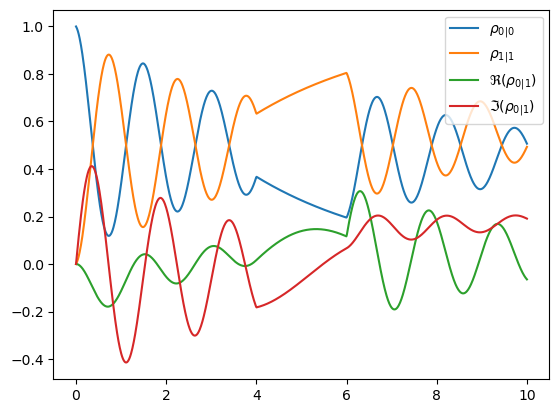

In [47]:
# Now set up the simuilation
sys = svp.ODESys(evoD, trans_dims ={}, driving_syms=[ES_r, ES_i], tSym=tS)
sys.set_driving({ES_r: lambda t: 2 if t<4 else 0, 
                 ES_i: lambda t: 2 if t<10 and t>6 else 0}) #
sys.set_initial_state(np.array([1,0,0]) )
model = sys.setup_model({T1S: 10}) # can substitute in any undefined parameters here

# And finally run it
tSteps = linspace(0,10,1000)
out = model.integrate(tSteps)

#Plot results (with nice legend)
figure()
for arr, sym in zip(out.swapaxes(0,1), sys.symsD.state):
    if sym.is_real:
        plot(tSteps,  arr.real, label =f"${sym}$" )
    else:
        plot(tSteps,  arr.real, label =fr"$\Re({sym})$" )
        plot(tSteps,  arr.imag, label =fr"$\Im({sym})$" )
legend()

In [44]:
sys.show_signatures()


**Function signatures:**

state_dep_f( $\displaystyle t$, dimAxes = $[  ]$, state = $[ \displaystyle \rho_{0|0}, \displaystyle \rho_{1|1}, \displaystyle \rho_{0|1} ]$, driving= $[ \displaystyle E_{r}, \displaystyle E_{i} ]$, intermediate = $[  ]$ )

output_f( $\displaystyle t$, dimAxes = $[  ]$, state = $[ \displaystyle \rho_{0|0}, \displaystyle \rho_{1|1}, \displaystyle \rho_{0|1} ]$, driving= $[ \displaystyle E_{r}, \displaystyle E_{i} ]$, state_dependent= $[  ]$ , intermediate = $[  ]$ )

The same thing again, but using a complex driving field

In [48]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS = sm.symbols('t', real=True)
ES = sm.symbols("E", complex=True)
H0 = 1*K2*K2.dag()
sig_m = K1*K2.dag() #+ K2*K1.dag() 
c_opL = [sqrt(.1)*K1*K2.dag()]

H_desc = [H0, [ES, sig_m], [sm.conjugate(ES), sig_m.dag()]]
evoD, ex_vals, pretty_eq=spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [sig_m], bReturnPrettyEquation=True)
#(diagL,diag_dtL), (cohL, coh_dtL), e_op_L = h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1])
display("Bloch equations:")
display(pretty_eq)
display("Expectation of polarisation:")
display(ex_vals)

'Bloch equations:'

<IPython.core.display.Latex object>

'Expectation of polarisation:'

In [49]:
sys.set_driving({ES_r: lambda t: 2 if t<4 else 0, 
                 ES_i: lambda t: 2 if t<10 and t>6 else 0}) #

In [50]:
sys = svp.ODESys(evoD,  trans_dims={}, driving_syms=[ES])
sys.set_driving({ES: lambda t: (2 if t<4 else 0) + (2j if t>6 and t<10 else 0j) })
sys.set_initial_state(np.array([1,0,0]) )
model = sys.setup_model()

CPU times: user 93.7 ms, sys: 1.68 ms, total: 95.4 ms
Wall time: 93.9 ms


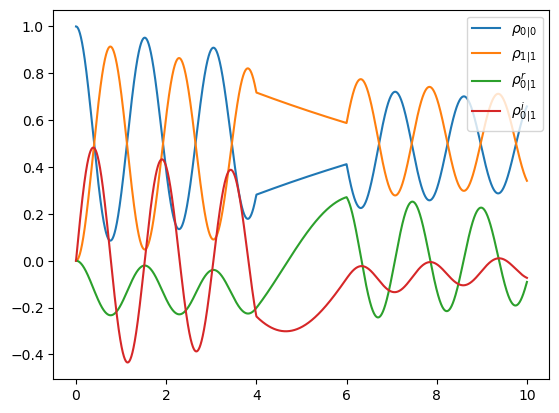

In [54]:
tSteps = linspace(0,10,10000)
%time out=model.integrate(tSteps)
#Plot results (with nice legend)
figure()
for arr, sym in zip(out.swapaxes(0,1), sys.symsD.state):
    if sym.is_real:
        plot(tSteps,  arr, label =f"${sym}$" )
    else:
        plot(tSteps,  arr.real, label =fr"$\Re({sym})$" )
        plot(tSteps,  arr.imag, label =fr"$\Im({sym})$" )
legend()

#### 2-level with Re-Im decomposition
Finally it's also possible to do a purely real simulation by decomposing all complex things to real and imaginary parts, first. For best performance this should probably be done by hand, then fed in. It can also do it somewhat automatically by passing in a flag, as long as the symbols are defined appropriately (they'll be assumed complex unless expliticly defined as real). This exists mainly added so that certain ODE solvers that don't support complex numbers can be tested, while still keeping the inputs complex. It's likely not very helpful if only using the standard scipy ones though. If you want real-only sims, you're better off starting from real-only evolution expressions (should put a flag into makeMEsymb!)


In [55]:
sys = svp.ODESys(evoD,  trans_dims={}, driving_syms=[ES], bDecompose_to_re_im=True)
sys.set_driving({ES: lambda t: (2 if t<4 else 0) + (2j if t>6 and t<10 else 0j)})
sys.set_initial_state( [1,0,0], bRealified=False ) # The bRealified flag is to say that we're giving the initial state as complex numbers.
model = sys.setup_model()

realified state dependent functions signature: (t, BoxList([]), BoxList([\rho_{0|0}, \rho_{1|1}, \rho_{0|1}]), BoxList([]), BoxList([E]))


CPU times: user 95.3 ms, sys: 2.85 ms, total: 98.2 ms
Wall time: 96.3 ms


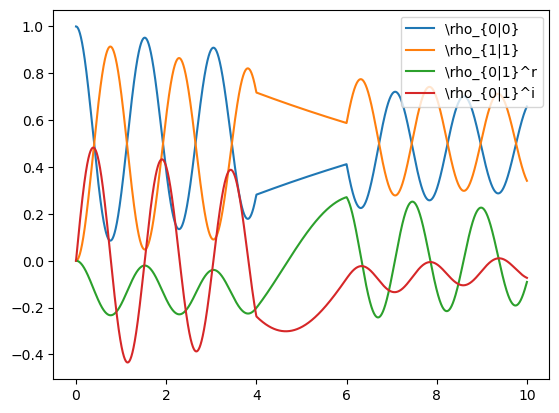

In [60]:
tSteps = linspace(0,10,10000)
%time out=model.integrate(tSteps)
plot(tSteps,  np.array(out).squeeze() )
legend(sys.symsD.state)

#### Comparison with qutip
How we'd do the same simulation in qutip. Hopefully it's the same answer as above! It's not really a 'fair' speed wise  though. because this could be made somewhat faster quite easily. It's a good check of results though

CPU times: user 616 ms, sys: 52.3 ms, total: 669 ms
Wall time: 590 ms


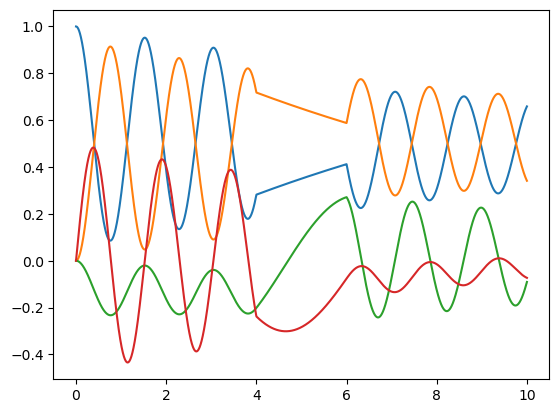

In [61]:
H0 = 1*K2*K2.dag()
H1 = K1*K2.dag() + K2*K1.dag() #2*sigmax()
c_opL = [sqrt(.1)*K1*K2.dag()]
#%time res=q.mesolve([ H0, [sqrt(1)*q.sigmax(), lambda t,_: 2 if t<4 else 0], [sqrt(1)*q.sigmay(), lambda t,_: 2 if t>6 and t<10 else 0 ]], K1, tSteps, c_ops = c_opL, e_ops=[K1*K1.dag(), K2*K2.dag(), K1*K2.dag(),1j*K1*K2.dag() ])
%time res=q.mesolve([ H0, [sqrt(1)*q.sigmax(), lambda t: 2 if t<4 else 0], [sqrt(1)*q.sigmay(), lambda t: 2 if t>6 and t<10 else 0 ]], K1, tSteps, c_ops = c_opL, e_ops=[K1*K1.dag(), K2*K2.dag(), K1*K2.dag(),1j*K1*K2.dag() ])

plot(tSteps, res.expect[0])
plot(tSteps, res.expect[1])
plot(tSteps, res.expect[2])
plot(tSteps, res.expect[3])

### 3-level system
Now just add some levels. 
We'll stick to complex E from now on, only because it's what I'm used to. 

Consider two grounds states (|1> and |2>) and an optical excited state (|3>).  The optical excited state is driven by one field, the ground state transition by another. There is slow thermalisation between the ground states, while the excited state decays to both of them equally

In [62]:
K2*K1.dag()

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0. 0.]
 [1. 0.]]

In [63]:
K1, K2, K3 = q.basis(3,0), q.basis(3,1), q.basis(3,2)
tS= sm.symbols('t', real=True)
ES_opt, ES_rf = sm.symbols("E_opt, E_rf", complex=True) # Two fields present. 
H0 = 1*K2*K2.dag() + 0*K3*K3.dag() # States 1 and 3 are degnerate, while K2 is split.
s1 = K3*K1.dag() + 0.2*K3*K2.dag()# couples state 1 and 3 strongly, and weak coupling from grounds state 2
s2 = K1*K2.dag()/2 # couples states 2 and 3

c_opL = [sqrt(0.2)*K1*K3.dag(), sqrt(0.2)*K2*K3.dag(), # Relaxation from optical states to ground states
         sqrt(0.05)*K1*K2.dag(), sqrt(0.05)*K2*K1.dag()] # Slow rethermalisation between ground states
H_desc = [H0, [ES_opt, s1.dag()], [sm.conjugate(ES_opt), s1],
            [ES_rf, s2.dag()], [sm.conjugate(ES_rf), s2]]
evoD, expect_vals, pretty_eq=spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [s1], bReturnPrettyEquation=True)

display("Bloch equations:")
display(pretty_eq)
display("Polarisation:")
display(expect_vals)

'Bloch equations:'

<IPython.core.display.Latex object>

'Polarisation:'

In [64]:
ode_s = svp.ODESys(evoD,  trans_dims={}, driving_syms=[ES_opt, ES_rf])
def f_opt(t): #Can also use plain python functions
    if t> 30: #Start driving the optical transition at t=30
        val = .3
    else:
        val = 0
    return val
def f_rf(t): # Rf pi pulse at t=5
    if t> 5 and t<6:
        val = np.pi
    else: 
        val = 0
    return val
#ode_s.set_driving({ES: lambda t: 5 + 1*t**2})
ode_s.set_driving({ES_opt: f_opt, ES_rf: f_rf})
ode_s.set_initial_state(np.array([1,0,0,0,0,0]) ) # Start from a ground state 1
model= ode_s.setup_model()

CPU times: user 68.7 ms, sys: 904 μs, total: 69.6 ms
Wall time: 67.8 ms


<>:10: SyntaxWarning: invalid escape sequence '\R'
<>:11: SyntaxWarning: invalid escape sequence '\I'
<>:10: SyntaxWarning: invalid escape sequence '\R'
<>:11: SyntaxWarning: invalid escape sequence '\I'
/tmp/ipykernel_129338/3231810025.py:10: SyntaxWarning: invalid escape sequence '\R'
  leg = ['$\Re({})$'.format(st) for st in  ode_s.symsD.state[3:]] + \
/tmp/ipykernel_129338/3231810025.py:11: SyntaxWarning: invalid escape sequence '\I'
  ['$\Im({})$'.format(st) for st in  ode_s.symsD.state[3:]]
/home/morgan/miniforge3/envs/spylind/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/morgan/miniforge3/envs/spylind/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'coherence terms')

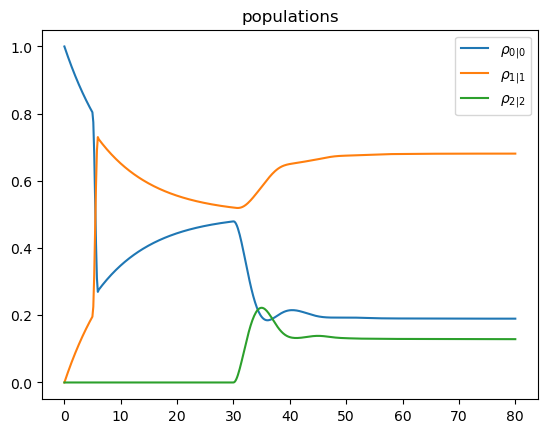

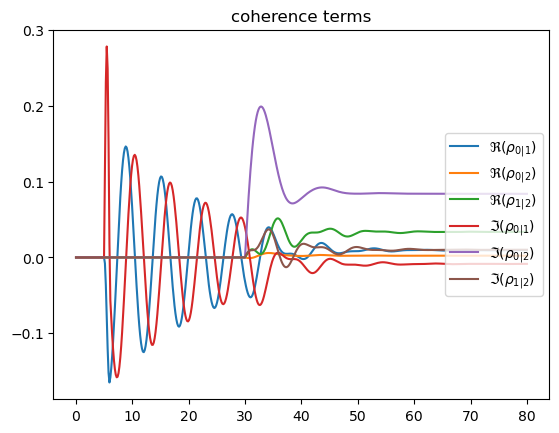

In [65]:
tSteps = linspace(0,80,500)
%time res = model.integrate(tSteps)
plot(tSteps,  res[:,:3] )
legend(['${}$'.format(st) for st in  ode_s.symsD.state[:3]]) # put $ signs around the symbols so they're rendered nicely
title("populations")

figure()
plot(tSteps,  res[:,3:].real )
plot(tSteps,  res[:,3:].imag )
leg = ['$\Re({})$'.format(st) for st in  ode_s.symsD.state[3:]] + \
    ['$\Im({})$'.format(st) for st in  ode_s.symsD.state[3:]]
legend(leg, loc='right')
title("coherence terms")
#legend(['${}$'.format(st) for st in  ode_s.symsD.state[3:]]) # put $ signs around the symbols so they're rendered nicely
#ylim([0,0.01])

## OBEs with inhomogeneous broadening (introduce a detuning axis)
The above was all things that you'd be better off using qutip for.

Now we consider larger ensembles, where qutip starts becoming impractical.
First we'll just consider a bunch of atoms that don't interact with each other, but each of which has a different detuning. 
This is essentially just an ensemble of simulations peformed in parallel

2 main changes to previous sim:

1. The coefficient for H0 is now a symbol, $\Delta$, corresponding to the detuning. 
2. We add an axis for $\Delta$ to the 'dims' argument when making an ODESys. This argument is a dictionary of symbols with the axis they're defined over- in this case, dims= `{DeltaS: linspace(-1,1,1000)}`. 

### 2-level, large-ish inhomogeneous broadening

In [66]:
# Make the atom equations
K1, K2  = q.basis(2,0), q.basis(2,1)
tS, DeltaS= sm.symbols('t,  Delta', real=True)
ES = sm.symbols("E")
H0 = 2*np.pi*K2*K2.dag()
sl = K2*K1.dag() #Lowering operator for atoms
c_opL = [sqrt(0.03)*K1*K2.dag()]

H_desc = [1*H0, [DeltaS, H0],[ES, sl], [sm.conjugate(ES), sl.dag()] ]#  [ES, H1]]
evoD, ex_vals, pretty_eq =spl.makeMESymb(H_desc, c_opL=c_opL, bReturnPrettyEquation=True)
display("Bloch equations:")
display(pretty_eq)

'Bloch equations:'

<IPython.core.display.Latex object>

In [67]:
sys = svp.ODESys(evoD, tSym=tS,  trans_dims={DeltaS: np.linspace(-2,2,1000)}, driving_syms=[ES_r, ES_i])

f_drv = 1.0
sys.set_driving({ES: lambda t: 0.2*np.exp(f_drv*1j*2*np.pi*t) })
p0 = np.zeros( (3,1000), dtype='c16' )
p0[2] = 1
sys.set_initial_state([1,0,0])


In [68]:
tSteps = np.linspace(0,10,2000)
model = sys.setup_model()
%time res = model.integrate(tSteps)
display(res.shape)

CPU times: user 306 ms, sys: 39.9 ms, total: 346 ms
Wall time: 346 ms


/home/morgan/miniforge3/envs/spylind/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/morgan/miniforge3/envs/spylind/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'atoms off resonance')

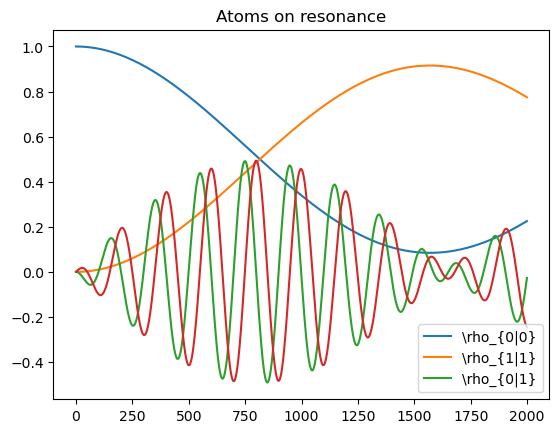

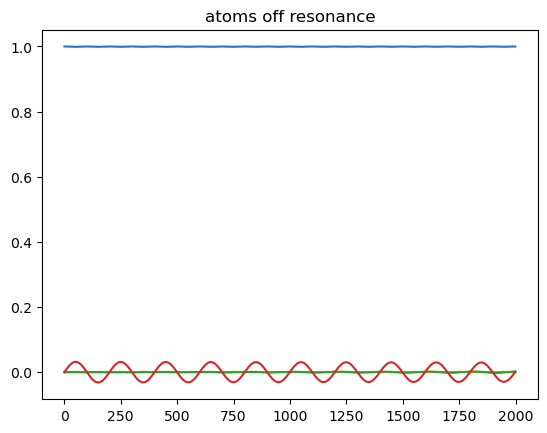

In [69]:
plot(  res[:,:,500] )
plot(  res[:,2,500].imag )
legend(sys.symsD.state)
title("Atoms on resonance")
figure()
plot(  res[:,:,0] )
plot(  res[:,2,0].imag )
title("atoms off resonance")

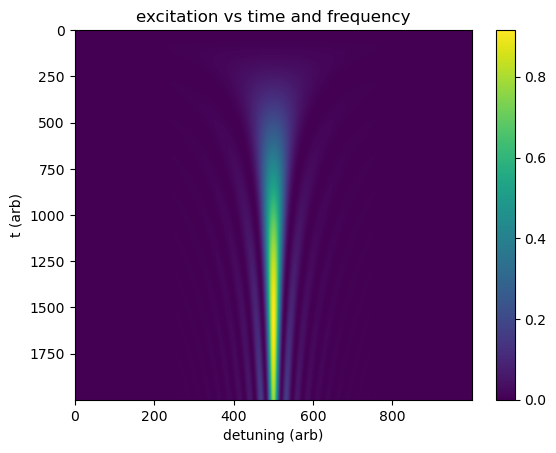

In [70]:
imshow(res[:,1].real, aspect='auto')
xlabel("detuning (arb)")
ylabel('t (arb)')
title('excitation vs time and frequency')
colorbar()

## Driven, interacting atoms (i.e. satellite lines)
A pair of interaction quantum systems at each 'site'. This is again defined pretty much the same as in qutip, but there are minor differences

We'll model interacting ions with slightly different energy excited states. There is a diagonal interaction between them, i.e. the energy of the system increases when both atoms are excited at the same time. In this case, to get both atoms excited, we must first excite one, then the other, taking into account the energy due to the interaction.

Define product states in the usual way one does in qutip. Here we're just doing 2 2-level system. We're using 'a' to represent an optical decay operator. That's mostly because it's easy to write, and it is something like an annihilation operator. The other option would be to write it as $\sigma_-$, but that's not quite right either

In [71]:
def K(state1, state2):
    return T(q.basis(2,state1), q.basis(2,state2) )

In [221]:
T = q.tensor # For brevity
eig_ket = lambda ion1, ion2: T(q.basis(2,ion1), q.basis(2,ion2))
# DEFINE OPERATORS
_ID = q.qeye(2) #Identity operator
_sm = q.basis(2,0)*q.basis(2,1).dag() # |0><1| (Single atom decay from excited state to ground state
sm1 = T(_sm, _ID) # lowering operator for atom 1 (e.g. sigma-minus)
sm2 = T(_ID, _sm) #Lowering operator for atom 2
sm_both = T(_sm, _sm) #Lower both atoms simultaneously
N1 = sm1.dag()*sm1 #Number operators for site 1
N2 = sm2.dag()*sm2 #Number operator for site 2
N_both = 0.5*sm_both.dag()*sm_both #Operator for both atoms excited at the same time

H0 = 1*N1 + .8*N2  #Excited states have similar energy
Hint = N_both
H1 = (sm1 + 1*sm2) # field H drives atom 1 more than atom2
T1 = 100.
c_opL = [sqrt(1./T1)*sm1, sqrt(1./T1)*sm2]

Text(0.5, 1.0, 'splitting due to H0, H0 + H_int')

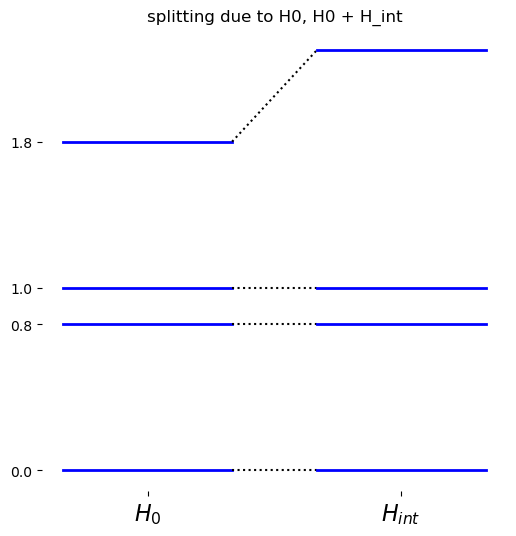

In [222]:
q.plot_energy_levels([H0, Hint], labels=['$H_0$', '$H_{int}$'], show_ylabels=True, figsize=(6,6))
title("splitting due to H0, H0 + H_int")

As can be seen above, the interaction ($H_{int}$) increases the energy of the uppermost state, which corresponds to both atoms being excited

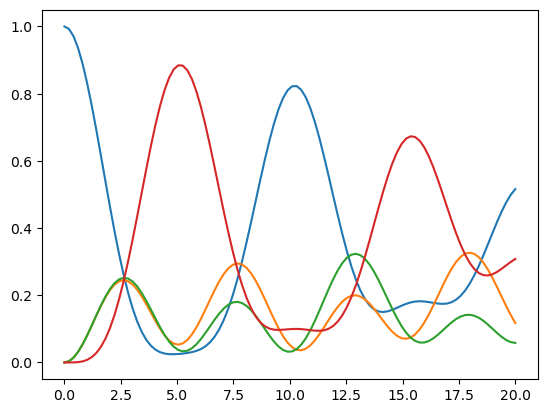

In [223]:
#QUTIP
tSteps = linspace(0,20,100)
Ef = lambda t: -.3*np.exp(1j*t)
res=q.mesolve( [H0, [H1, lambda t,_: Ef(t)],  [H1.dag(), lambda t,_: conjugate(Ef(t))], [Hint, lambda t,_: 0.5]], eig_ket(0,0), tlist=tSteps, c_ops=c_opL, e_ops=[ket*ket.dag() for ket in Hint.eigenstates()[1]])
plot(tSteps, array(res.expect).T)

In [224]:
#Construct the symbollic simulation
tS, etaS = sm.symbols('t, eta', real=True)
ES = sm.symbols("E", complex=True)
H_desc = [H0, [ES, H1], [sm.conjugate(ES), H1.dag()], [etaS, Hint]]
rhoS = spl.getTensoredRhoS('01', 'ab') #Setting nice symbol labels for the density matrix can make it easier to interpret results
# Here '01' are the state labels of the first system (i.e. atom 1) and 'ab' are the state labels of the second (atom 2). 
evoD, ex_vals, pretty_eq = spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1], bReturnPrettyEquation=True, rhoS=rhoS)
display(pretty_eq)

<IPython.core.display.Latex object>

In [240]:
sys = svp.ODESys(evoD, tSym=tS,  trans_dims={etaS: linspace(0,1,100)}, driving_syms=[ES], bDecompose_to_re_im=True)

initial_state = np.tile(np.array([1, 0.0, 0, 0] +11*[0]), (100,1) ).T
#sys.set_initial_state(initial_state)
Ef = lambda t: -.3*np.exp(-1j*t)
sys.set_initial_state([1] + 15*[0])
sys.set_driving({ES: Ef})
model = sys.setup_model()

realified state dependent functions signature: (t, BoxList([eta]), BoxList([\rho_{00|aa}, \rho_{00|bb}, \rho_{11|aa}, \rho_{11|bb}, \rho_{00|ba}, \rho_{10|aa}, \rho_{10|ba}, \rho_{10|ab}, \rho_{10|bb}, \rho_{11|ba}]), BoxList([]), BoxList([E]))


In [243]:
tSteps = linspace(0,20,100)
%time res = model.integrate(tSteps)

CPU times: user 475 ms, sys: 8.25 ms, total: 483 ms
Wall time: 468 ms


Text(0, 0.5, 'interaction strength, $\\eta$')

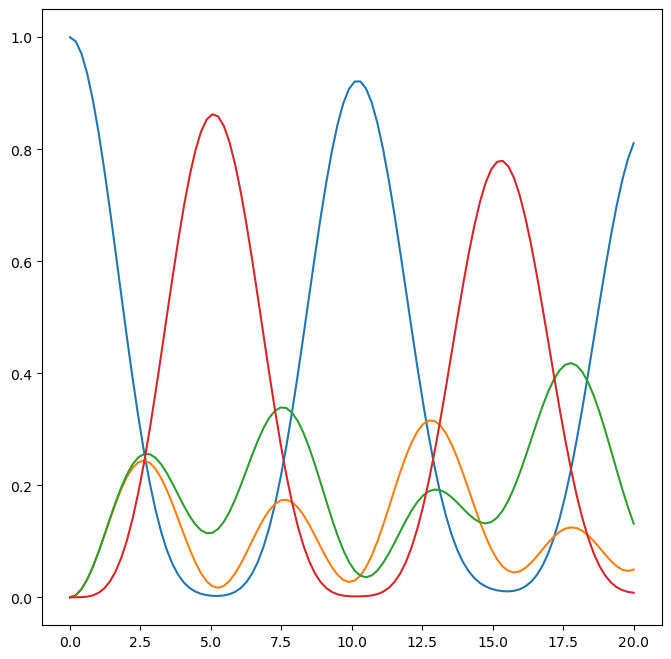

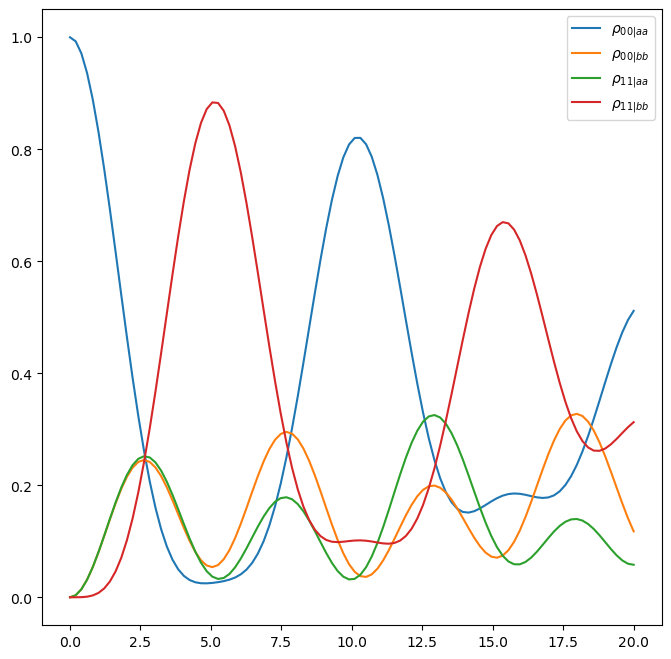

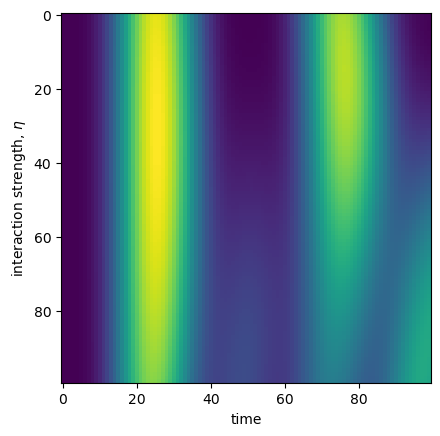

In [244]:
figure(figsize=(8,8))
plot(tSteps, res[:,:4, 0] )
figure(figsize=(8,8))
plot(tSteps, res[:,:4, 50] )

#plot(tSteps,  arr.imag )
#ylim([-0.2, 0.5])
legend([r'${}$'.format(sym) for sym in sys.symsD['state'][:4]], loc='best')
figure()
imshow(res[:,3].real.T)
xlabel('time')
ylabel('interaction strength, $\eta$')

remember, the first indices (numbers) correspond to the state of the first atom, while the second set of indices (letters) correspond to the state of the second

# MBEs

In [ ]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS, zS = sm.symbols('t, z', real=True)
EexS,EintS, EtotS = sm.symbols('E_ex, E_int, E_tot', complex=True)
E_subs_D = {EtotS: EexS + EintS}
H0 = 1*K2*K2.dag()
H1a = K2*K1.dag() 
H1b = K1*K2.dag()
#sx=K2*K1.dag() + K1*K2.dag()
#sy=1j*K2*K1.dag() - 1j*K1*K2.dag()
c_opL = [sqrt(1)*K1*K2.dag() ]
#H_desc = [ [EexS+EintS, H1a], [sm.conjugate(EexS) + sm.conjugate(EintS), H1b] ]
H_desc = [H0, [EtotS, H1a], [sm.conjugate(EtotS), H1b]]

evoD, [pol_expr], pretty_eq = spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1a], bReturnPrettyEquation=True)
display(pretty_eq)
display(pol_expr)

# State dependent examples
Now the evolution can depend on state- so atoms can affect each other. Now we have to define dependence __between__ atoms. A "state dependent function" for our purposes is the most general- it'll get the full state, as well as driving terms and dimensions as inputs.

## Letting atoms make light
Above is light affecting atoms. Now we consider atoms making light, 'affecting' the light in turn. We consider only 1D below, with the propagation direction $z$. We assume that the total field at a given point is the sum of the field due to externally input field ($E_{ex}(z)$) and the field due to the radiation of atoms, $E_{int}(z)$. So if a medium is totally absorbing, this means that at the output  $E_{ex} = - E_{int}$.

## 1-way MBEs 

First let's consider the the simplest '1-way' case. Light entes from one side of the medium and exits from the other. For this to be true, the slowly-varying envelope approximation in space must hold. That is, there is no large change on the scale of a wavelength, as this would cause reflections and thus light travelling in both directions. In this approximation, the spatial phase variation of the light as it propagates forward ($e^{ikz}$) is a given and can be factored out, and we only care about variations from that. This looks alot like setting the wavevector to zero (wavlength to infinite). We could have similar maths with a so-called 'moving frame' picture. But, s long as the fields are also slowly varying in time compared to the propagation time for light in the medium, this 'moving frame' interpretation isn't necessary. It confuses things, and it breaks in the following examples anyway (when we'll asssuming this very slowly varying envelope approximation w.r.t to the medium transit time)

The field at position $z$ is just the field applied externally ($E_{ex}$) plus the sum of the field caused by polarisation of all atoms before it- $\int_0^z iP(z)\,dz$. Where $P(z)$ is the atom polarisation. It's proportional to the expectation value of the dipole operator. That is, the atoms' dipole operator is responsible both for field driving atoms and atoms driving field.


In [145]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS, zS = sm.symbols('t, z', real=True)
EexS,EintS, EtotS = sm.symbols('E_ex, E_int, E_tot', complex=True)
E_subs_D = {EtotS: EexS + EintS}
H0 = 1*K2*K2.dag()
H1a = K2*K1.dag() 
H1b = K1*K2.dag()
#sx=K2*K1.dag() + K1*K2.dag()
#sy=1j*K2*K1.dag() - 1j*K1*K2.dag()
c_opL = [sqrt(1)*K1*K2.dag() ]
#H_desc = [ [EexS+EintS, H1a], [sm.conjugate(EexS) + sm.conjugate(EintS), H1b] ]
H_desc = [H0, [EtotS, H1a], [sm.conjugate(EtotS), H1b]]

evoD, [pol_expr], pretty_eq = spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1a], bReturnPrettyEquation=True)
display(pretty_eq)
display("Pol is prop. to: ", pol_expr)

<IPython.core.display.Latex object>

'Pol is prop. to: '

In [146]:
lhsL, rhsL = spl.seperate_DM_equation(eq.subs(E_subs_D))
pol_expr = pol_expr.subs(E_subs_D)
E_rad_expr = sm.I*pol_expr
#zAxx = lin
sys = svp.ODESys(dict(zip(lhsL, rhsL) ),  trans_dims={zS: linspace(0,1,1000)}, driving_syms=[EexS])
polF=sm.lambdify( sys.symsD['prop_state_syms'],pol_expr, dummify=True)

    
zAx = sys.dimAxes[0]
dz = zAx[1]-zAx[0]
OD = 1
def calcPolFieldF(t, dimAxs,state,driving, interaction_factor= 1j*OD*dz):
    pol = polF(*state)
    P = np.cumsum(polF(*state))*interaction_factor
    return P
calcPolFieldF.num=0


Ein_expr = sm.Piecewise(
    (-0.1, tS < 20),
    (0, True),
)
EinF = sm.lambdify(tS, Ein_expr, 'numpy')
#sys.set_driving({EexS: lambda t: -0.5 if t<20 else 0})
sys.set_driving({EexS: Ein_expr})
sys.set_state_dependence({EintS:calcPolFieldF})
sys.set_initial_conditions(np.tile(array([1,0,0]), (zAx.size,1) ).T.astype('c16'))
model= sys.setup_model()


NameError: name 'eq' is not defined

In [230]:
tSteps = linspace(0,30,2000)
%time res = model.integrate(tSteps)

Not integrating first step (it's just the initial state)
CPU times: user 430 ms, sys: 130 ms, total: 560 ms
Wall time: 563 ms


/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


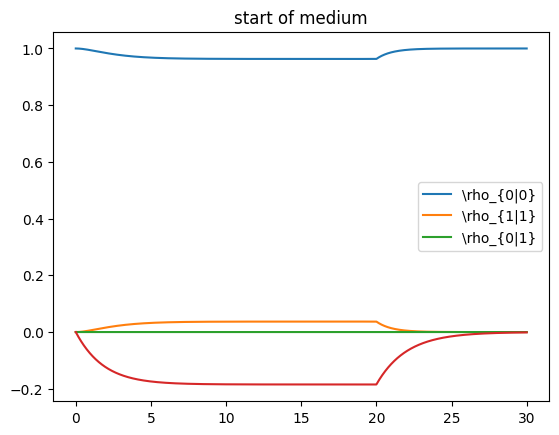

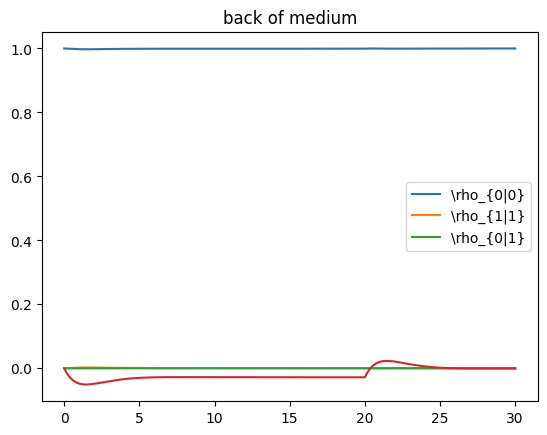

In [232]:
figure()
plot(tSteps,  res[:,:,0].squeeze() )
plot(tSteps,  res[:,2,0].squeeze().imag )
legend(sys.symsD['prop_state_syms'])
title('start of medium')
figure()
plot(tSteps,  res[:,:,-1].squeeze() )
plot(tSteps,  res[:,2,-1].squeeze().imag )
title('back of medium')

legend(sys.symsD['prop_state_syms'])

/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


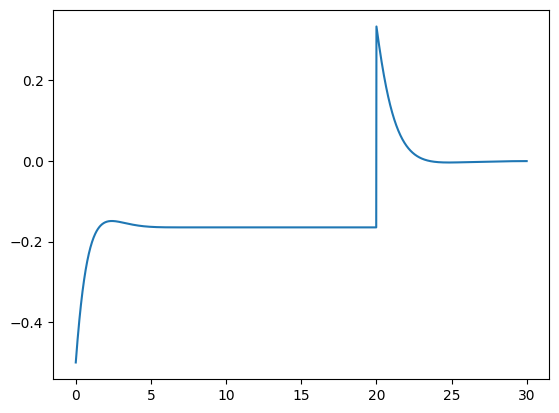

In [226]:
Eout = (EinF(tSteps) +polF(*res.transpose((1,0,2))).sum(axis=1)*dz*OD*1j )
plot(tSteps,  Eout)

Text(0.5, 1.0, 'excitation')

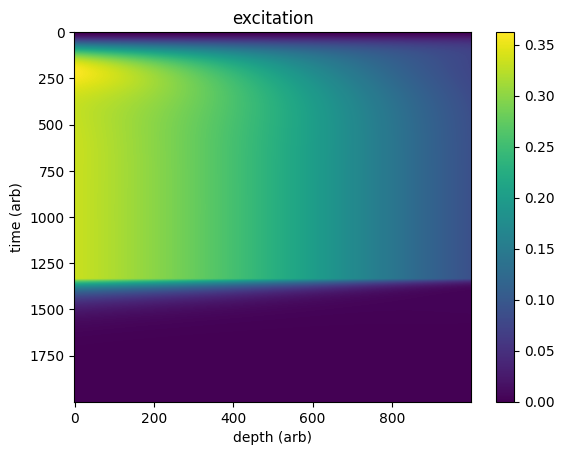

In [22]:
imshow(res[:,1].real, aspect='auto')
colorbar()
xlabel('depth (arb)')
ylabel('time (arb)')
title('excitation')

## 1-way MBEs with inhomogenous broadening

In [2]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS, zS, DeltaS = sm.symbols('t, z, Delta', real=True)
EexS,EintS, EtotS = sm.symbols('E_ex, E_int, E_tot', complex=True)
E_subs_D = {EtotS: EexS + EintS}
H0 = 1*K2*K2.dag()
H1a = K2*K1.dag() 
H1b = K1*K2.dag()

c_opL = [sqrt(.3)*K1*K2.dag() ]
#H_desc = [H0, [EexS+EintS, H1a], [sm.conjugate(EexS) + sm.conjugate(EintS), H1b]]
H_desc = [0*H0, [EexS + EintS, H1a], [sm.conjugate(EexS + EintS), H1b], [DeltaS, 2*pi*H0] ]

evoD, [pol_expr],pretty_eq= spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1a], bReturnPrettyEquation=True)
display(pretty_eq)
display(pol_expr)

<IPython.core.display.Latex object>

/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/si

In [49]:
#lhsL, rhsL = spl.seperate_DM_equation(eq.subs(E_subs_D))
#pol_expr = pol_expr.subs(E_subs_D)
sys = svp.ODESys(evoD,  dims={zS: linspace(0,1,30), DeltaS : linspace(-2,2,400)}, 
                 driving_syms=[EexS])

#polF=sm.lambdify( sys.symsD['prop_state_syms'],pol_expr)
polF=sm.lambdify( evoD.keys(), pol_expr)
zAx = sys.dimAxes[0]
deltaAxInd = sys.dimSyms.index(DeltaS)
zAxInd = sys.dimSyms.index(zS)
deltaAx = sys.dimAxes[deltaAxInd]
dDelta = deltaAx[1]- deltaAx[0]
dz = zAx[1]-zAx[0]
peak_OD = 1.

absorption_lineshape = 1*np.ones_like(deltaAx)
# Integrate over detuning and space to give polarisation field.
# This is scaled to give a peak OD with the assumption that inhomogeneous >> homogeneous broadening
scaled_lineshape = absorption_lineshape*peak_OD*(dDelta/zAx.size) 
def calcPolFieldF(t, dimAxs,state,driving, lineshape = scaled_lineshape):
    pol = (polF(*state)*lineshape[newaxis, :]).sum(axis=deltaAxInd, keepdims=True)
    P = np.cumsum(pol, axis= zAxInd)
    return 1j*P

Ein_expr = sm.Piecewise( # We can define the input analytically using sympy
    (-0.1, tS < 5),
    (0, True),
)
EinF = sm.lambdify(tS, Ein_expr)
#sys.set_driving({EexS: lambda t: -0.5 if t<20 else 0})

sys.set_driving({EexS: Ein_expr})
sys.set_state_dependence({EintS:calcPolFieldF})
sys.set_initial_conditions(array([1,0,0], dtype='c16'))
model= sys.setup_model()

Munch({'tSym': t, 'dimSyms': [z, Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}], 'stationary_state_syms': [], 'driving_syms': [E_ex], 'state_dep_syms': [Delta, E_int]})
state dependent functions should have signature [t, z, Delta, \rho_{0|0}, \rho_{1|1}, \rho_{0|1}, E_ex]
{} {E_ex: <function _lambdifygenerated at 0x7fe38b6d89d0>}


In [50]:
tSteps = linspace(0,10,2000)
%time res = model.integrate(tSteps)

Not integrating first step (it's just the initial state)
CPU times: user 4.26 s, sys: 845 ms, total: 5.1 s
Wall time: 5.12 s


/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


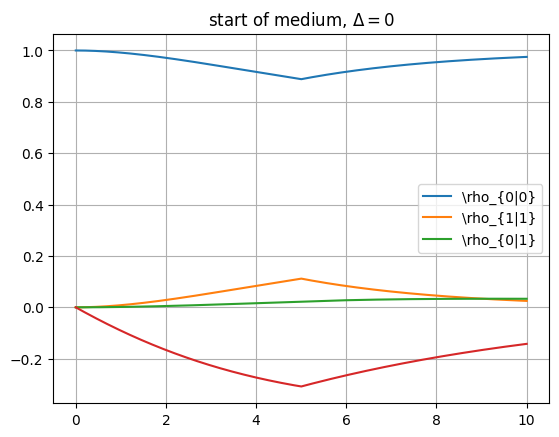

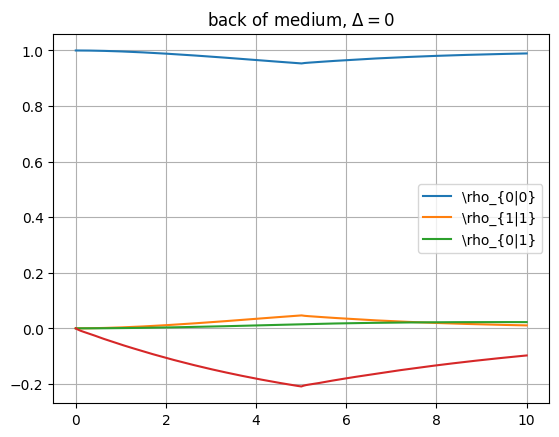

In [51]:
figure()
plot(tSteps,  res[:,:,0, deltaAx.size//2])
plot(tSteps,  res[:,2,0, deltaAx.size//2].imag )
legend(sys.symsD['prop_state_syms'])
title('start of medium, $\Delta = 0$')
grid()
figure()
plot(tSteps,  res[:,:,-1, deltaAx.size//2])
plot(tSteps,  res[:,2,-1, deltaAx.size//2].imag )
title('back of medium, $\Delta = 0$')
grid()

legend(sys.symsD['prop_state_syms'])

Text(0.5, 1.0, 'excitation at final time')

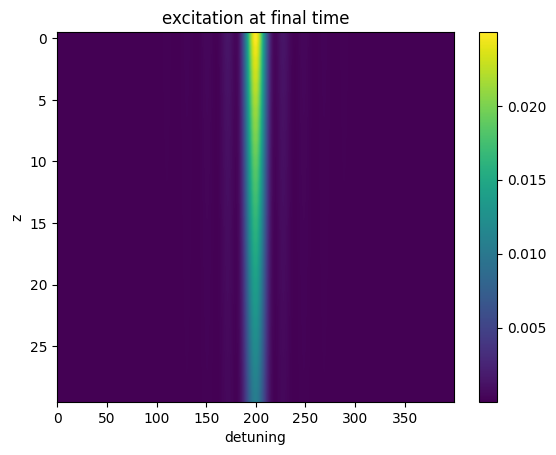

In [52]:
imshow(res[-1][1].real, aspect='auto',);
colorbar()
xlabel('detuning')
ylabel('z')
title('excitation at final time')

### Calculate output field

Text(0, 0.5, 'amplitude')

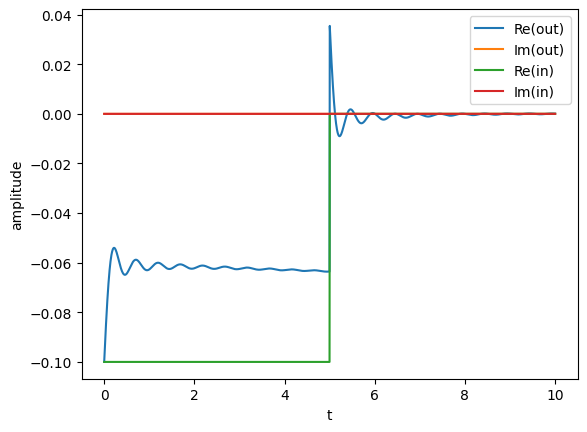

In [52]:
state = np.moveaxis(res, 0,-1) #Move the time axis to the end, so state axis is at the start 
                                #and we can use polF(*state)
pol = (polF(*state)*scaled_lineshape[newaxis, :, newaxis]).sum(axis=deltaAxInd) # This comes from calcPolFuncF
Ein = EinF(tSteps)
Eout = 1j*pol.sum(axis=0) + Ein
plot(tSteps, Eout.real, label='Re(out)')
plot(tSteps, Eout.imag, label='Im(out)')

plot(tSteps, Ein.real, label='Re(in)')
plot(tSteps, Ein.imag, label='Im(in)')
legend()
xlabel('t')
ylabel('amplitude')

## Two different input fields

Now consider the situation where the atoms are driven by two different fields, each of which affects different transitions. The two fields could represent very different frequencies, i.e. for driving far removed transitions, or different polarisation.

First we'll do polarisation. For this, we'll consifer a fully polarised, electric dipole transition. I'd guess the case when it's part-electric part-magnetic would be done by adding another term (but I haven't thought about it).

It would also be easy enough to add different refractive indices for the different polarisations, but this will be more clear after looking at two way simulations below.

In [317]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS, zS, DeltaS = sm.symbols('t, z, Delta', real=True)
EHexS,EHintS, = sm.symbols('E^H_ex, E^H_int', complex=True)
EVexS,EVintS, = sm.symbols('E^V_ex, E^V_int', complex=True)
H0 = 1*K2*K2.dag()

phi_tr_S = sm.symbols("phi", real=True);
theta_inp_S = sm.symbols("theta", real=True);
phi = 0.00001*pi
HHa = K2*K1.dag()*cos(phi)
HVa = K2*K1.dag()*sin(phi)

c_opL = [sqrt(.1)*K1*K2.dag() ]
HHa_coef = (EHexS + EHintS)
HVa_coef = (EVexS + EVintS)
#H_desc = [H0, [EexS+EintS, H1a], [sm.conjugate(EexS) + sm.conjugate(EintS), H1b]]
H_desc = [0*H0, [HHa_coef, HHa], [sm.conjugate(HHa_coef), HHa.dag()], 
          [HVa_coef, HVa], [sm.conjugate(HVa_coef), HVa.dag()], 
          [DeltaS*2*sm.pi, H0] ]

evoD, [pol_H_expr, pol_V_expr],pretty_eq= spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [HHa, HVa], bReturnPrettyEquation=True)
display(pretty_eq)
display([pol_H_expr, pol_V_expr])

<IPython.core.display.Latex object>

/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/si

In [291]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS, zS, DeltaS = sm.symbols('t, z, Delta', real=True)
EHexS,EHintS, = sm.symbols('E^H_ex, E^H_int', complex=True)
EVexS,EVintS, = sm.symbols('E^V_ex, E^V_int', complex=True)
H0 = 1*K2*K2.dag()

phi_tr_S = sm.symbols("phi", real=True);
theta_inp_S = sm.symbols("theta", real=True);
HVa = sm.Matrix(K2*K1.dag()) *sm.sin(phi_tr_S) # Making it a sympy matrix to keep things symbollic
HHa = sm.Matrix(K2*K1.dag())* sm.cos(phi_tr_S)  # Just have to replace '.dag()' with ".adjoint()"

c_opL = [sqrt(.1)*K1*K2.dag() ]

HHa_coef = (EHexS + EHintS)
HVa_coef = (EVexS + EVintS)
#H_desc = [H0, [EexS+EintS, H1a], [sm.conjugate(EexS) + sm.conjugate(EintS), H1b]]
H_desc = [0.00001*H0, [HHa_coef, HHa], [sm.conjugate(HHa_coef), HHa.adjoint()], 
          [HVa_coef, HVa], [sm.conjugate(HVa_coef), HVa.adjoint()], 
          [DeltaS*2*sm.pi, H0] ]

evoD, [pol_H_expr, pol_V_expr],pretty_eq= spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [HHa, HVa], bReturnPrettyEquation=True)
display(pretty_eq)
display([pol_H_expr, pol_V_expr])

<IPython.core.display.Latex object>

/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/si

In [318]:
#lhsL, rhsL = spl.seperate_DM_equation(eq.subs(E_subs_D))
#pol_expr = pol_expr.subs(E_subs_D)
sys = svp.ODESys(evoD,  dims={zS: linspace(0,6,600), DeltaS : linspace(-3,-2.90,3)}, 
                 driving_syms=[EexS])

#paramsD = {phi_tr_S:0.0001*pi/4}
#pol_H_F=sm.lambdify( evoD.keys(), pol_H_expr.subs(paramsD), 'numpy')
#pol_V_F=sm.lambdify( evoD.keys(), pol_V_expr.subs(paramsD), 'numpy')
#polF=sm.lambdify( sys.symsD['prop_state_syms'],pol_expr)
pol_H_F=sm.lambdify( evoD.keys(), pol_H_expr)
pol_V_F=sm.lambdify( evoD.keys(), pol_V_expr)

zAx = sys.dimAxes[0]
deltaAxInd = sys.dimSyms.index(DeltaS)
zAxInd = sys.dimSyms.index(zS)
deltaAx = sys.dimAxes[deltaAxInd]
dDelta = deltaAx[1]- deltaAx[0]
dz = zAx[1]-zAx[0]
peak_OD = 1000.

absorption_lineshape = 1*np.ones_like(deltaAx)
# This is scaled to give a peak OD with the assumption that inhomogeneous >> homogeneous broadening
scaled_lineshape = absorption_lineshape*peak_OD*(dDelta/zAx.size) 

def calc_H_polF(t, dimAxs,state,driving, lineshape = scaled_lineshape):
    pol = (pol_H_F(*state)*lineshape[newaxis, :]).sum(axis=deltaAxInd, keepdims=True)
    P = np.cumsum(pol, axis= zAxInd)
    return 1j*P

def calc_V_polF(t, dimAxs,state,driving, lineshape = scaled_lineshape):
    pol = (pol_V_F(*state)*lineshape[newaxis, :]).sum(axis=deltaAxInd, keepdims=True)
    P = np.cumsum(pol, axis= zAxInd)
    return 1j*P

Ein_expr = sm.Piecewise( # We can define the input analytically using sympy
    (-0.1, tS < 5),
    (0, True),
)
pol_angle = -pi/4
Ein_expr_H = cos(pol_angle)*Ein_expr
Ein_expr_V = sin(pol_angle)*Ein_expr

sys.set_driving({EHexS: Ein_expr_H, EVexS: Ein_expr_V })
sys.set_state_dependence({EHintS:calc_H_polF, EVintS:calc_V_polF})
sys.set_initial_conditions(array([1,0,0], dtype='c16'))

Munch({'tSym': t, 'dimSyms': [z, Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}], 'stationary_state_syms': [], 'driving_syms': [E_ex], 'state_dep_syms': [E^V_ex, E^H_ex, Delta, E^H_int, E^V_int]})
state dependent functions should have signature [t, z, Delta, \rho_{0|0}, \rho_{1|1}, \rho_{0|1}, E_ex]
{} {E^H_ex: <function _lambdifygenerated at 0x7fe364ed1e50>, E^V_ex: <function _lambdifygenerated at 0x7fe364ed1700>}


In [319]:
model= sys.setup_model(max_step=0.1, subsD = paramsD, bTryToSimplify=True)
tSteps = linspace(0,10,1000)
%time res = model.integrate(tSteps)

Not integrating first step (it's just the initial state)
CPU times: user 2.2 s, sys: 55 ms, total: 2.25 s
Wall time: 2.25 s


Now calculate output fields and plot it

/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


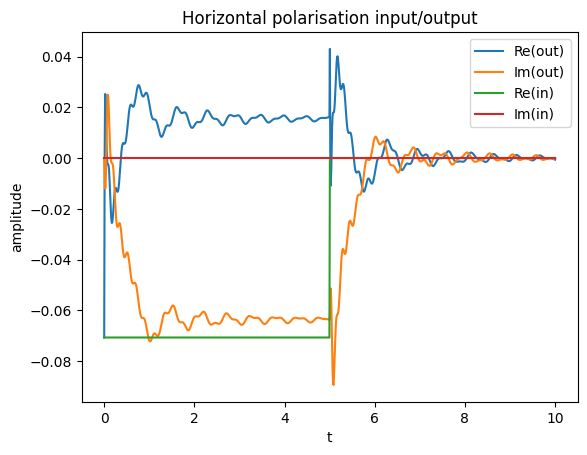

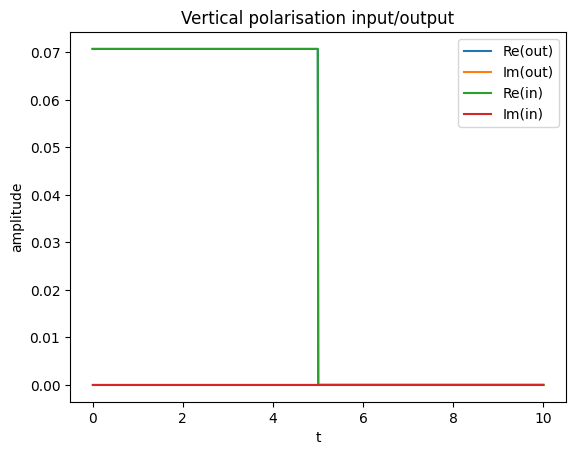

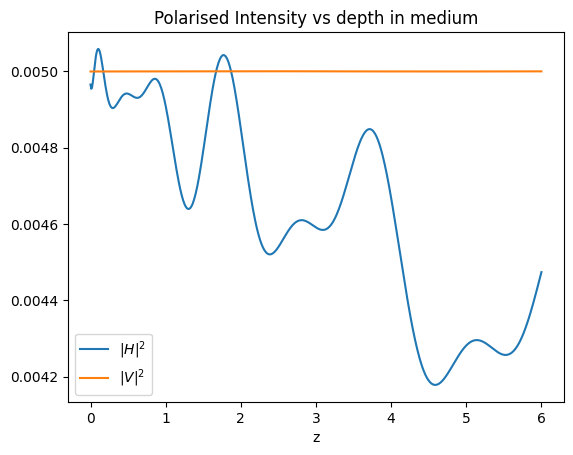

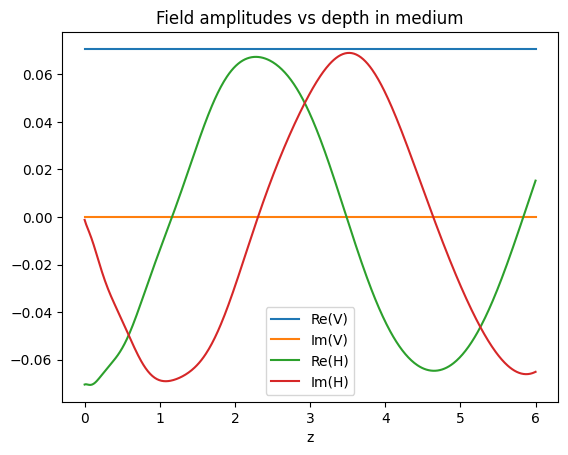

In [320]:
state = np.moveaxis(res, 0,-1) #Move the time axis to the end, so state axis is at the start 
                                #and we can use polF(*state)
pol_H = (pol_H_F(*state)*scaled_lineshape[newaxis, :, newaxis]).sum(axis=deltaAxInd) # This comes from calcPolFuncF
pol_V = (pol_V_F(*state)*scaled_lineshape[newaxis, :, newaxis]).sum(axis=deltaAxInd) # This comes from calcPolFuncF
Ein_H = sm.lambdify(tS, Ein_expr_H, 'numpy')(tSteps)
Ein_V = sm.lambdify(tS, Ein_expr_V, 'numpy')(tSteps)

Ein_V = zeros(tSteps.size) if np.size(Ein_V) == 1 else Ein_V # In case one direction is sympy collapses ths size
Ein_H = zeros(tSteps.size) if np.size(Ein_H) == 1 else Ein_H


Eout_H = 1j*pol_H.cumsum(axis=0)  + Ein_H[newaxis]
Eout_V = 1j*pol_V.cumsum(axis=0)  + Ein_V[newaxis]
plot(tSteps, Eout_H[-1].real, label='Re(out)')
plot(tSteps, Eout_H[-1].imag, label='Im(out)')
plot(tSteps, Ein_H.real, label='Re(in)')
plot(tSteps, Ein_H.imag, label='Im(in)')
legend()
xlabel('t')
ylabel('amplitude')
title("Horizontal polarisation input/output")

figure()
plot(tSteps, Eout_V[-1].real, label='Re(out)')
plot(tSteps, Eout_V[-1].imag, label='Im(out)')
plot(tSteps, Ein_V.real, label='Re(in)')
plot(tSteps, Ein_V.imag, label='Im(in)')
legend()
xlabel('t')
ylabel('amplitude')
title("Vertical polarisation input/output")

figure()
plot(zAx, np.abs(Eout_H[:,tSteps.size//4])**2, label = "$|H|^2$" )
plot(zAx, np.abs(Eout_V[:,tSteps.size//4])**2, label = "$|V|^2$")
xlabel("z")
title("Polarised Intensity vs depth in medium")
legend()

figure()
plot(zAx, Eout_V[:,tSteps.size//4].real, label="Re(V)")
plot(zAx, Eout_V[:,tSteps.size//4].imag, label="Im(V)")
plot(zAx, Eout_H[:,tSteps.size//4], label="Re(H)")
plot(zAx, Eout_H[:,tSteps.size//4].imag, label="Im(H)")
xlabel("z")
title("Field amplitudes vs depth in medium")
legend()

## Varying wave-vectors- backwards and forwards propagation, as well as varying wavelength

Here we consider effects due to the wavelength/wavevector of the light. In this case we can look at backwards propagating fields as well as forwards.

Now we must consider the propagation phase of the field, $e^{ikz}$- that is the fact the phase of the light cycles every wavelength in the medium. Light going forward/backwards propagates with wavevector $k \pm \frac{2pi}{\lambda}$.

Examples: 
* Will re-do the above but with different wave-vectors for the different polarisations- i.e. different refractive indices
* 


## Two polarisations with different wavelengths
Atoms are idenntical to above. The main changes are that 

* That the atom at position $z$ will see a field $E_{in} e^{ik_{H,V}z}$ due to input light polarised along $H$ or $V$
* Previously, the field due to polarisation at position $z$ was the straight sum of the atoms of the entire medium before it. Now, the field due to an earlier atom will also change phase as it propagates. Now, the polarisation field at position $z$ is $\int^{z}_{0} E(z)_{pol}e^{ikz} dz$. Of course if $k=0$, this reduces to the previous case.

To add this to the sim, we _could_ modify the Hamiltonian of atoms at position $z$ to include the phase change, or we could include this in the `calc_pol` functions. Since we have to modify those anyway, we'll leave the atoms alone and do all the changes in the caluclate_pol functions (it'll also be slightly faster)

In [318]:
#lhsL, rhsL = spl.seperate_DM_equation(eq.subs(E_subs_D))
#pol_expr = pol_expr.subs(E_subs_D)
sys = svp.ODESys(evoD,  dims={zS: linspace(0,6,600), DeltaS : linspace(-3,-2.90,3)}, 
                 driving_syms=[EexS])

#paramsD = {phi_tr_S:0.0001*pi/4}
#pol_H_F=sm.lambdify( evoD.keys(), pol_H_expr.subs(paramsD), 'numpy')
#pol_V_F=sm.lambdify( evoD.keys(), pol_V_expr.subs(paramsD), 'numpy')
#polF=sm.lambdify( sys.symsD['prop_state_syms'],pol_expr)
pol_H_F=sm.lambdify( evoD.keys(), pol_H_expr)
pol_V_F=sm.lambdify( evoD.keys(), pol_V_expr)

zAx = sys.dimAxes[0]
deltaAxInd = sys.dimSyms.index(DeltaS)
zAxInd = sys.dimSyms.index(zS)
deltaAx = sys.dimAxes[deltaAxInd]
dDelta = deltaAx[1]- deltaAx[0]
dz = zAx[1]-zAx[0]
peak_OD = 1000.

absorption_lineshape = 1*np.ones_like(deltaAx)
# This is scaled to give a peak OD with the assumption that inhomogeneous >> homogeneous broadening
scaled_lineshape = absorption_lineshape*peak_OD*(dDelta/zAx.size) 

def calc_H_polF(t, dimAxs,state,driving, lineshape = scaled_lineshape):
    pol = (pol_H_F(*state)*lineshape[newaxis, :]).sum(axis=deltaAxInd, keepdims=True)
    P = np.cumsum(pol, axis= zAxInd)
    return 1j*P

def calc_V_polF(t, dimAxs,state,driving, lineshape = scaled_lineshape):
    pol = (pol_V_F(*state)*lineshape[newaxis, :]).sum(axis=deltaAxInd, keepdims=True)
    P = np.cumsum(pol, axis= zAxInd)
    return 1j*P

Ein_expr = sm.Piecewise( # We can define the input analytically using sympy
    (-0.1, tS < 5),
    (0, True),
)
pol_angle = -pi/4
Ein_expr_H = cos(pol_angle)*Ein_expr
Ein_expr_V = sin(pol_angle)*Ein_expr

sys.set_driving({EHexS: Ein_expr_H, EVexS: Ein_expr_V })
sys.set_state_dependence({EHintS:calc_H_polF, EVintS:calc_V_polF})
sys.set_initial_conditions(array([1,0,0], dtype='c16'))

Munch({'tSym': t, 'dimSyms': [z, Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}], 'stationary_state_syms': [], 'driving_syms': [E_ex], 'state_dep_syms': [E^V_ex, E^H_ex, Delta, E^H_int, E^V_int]})
state dependent functions should have signature [t, z, Delta, \rho_{0|0}, \rho_{1|1}, \rho_{0|1}, E_ex]
{} {E^H_ex: <function _lambdifygenerated at 0x7fe364ed1e50>, E^V_ex: <function _lambdifygenerated at 0x7fe364ed1700>}


## 2-way SVEA MBEs with a cavity.

Driving from two field directions at once. The main reason to do this (I think) is to look at the effects of a cavity.

Ultimately the driving field for the atoms will be given by a state dependent value $E_{tot}$ which has contributions from $E_{inp,F}(t), E_{inp,R}$ and $E_{pol}(t, \rho)$. Each step it's calculating the space dependent polarisation $E_{pol}(z)$, then using this to calculate the forward and backwards moving polarisation due to atoms alone. Then use the final value to calculate the contribution of any extra modes (e.g due to reflections due to a cavity) who's spatial dependence is pre-calcuated. These weighted modes are then summed with the moving polarisation modes to give $E_{tot}(z)$


In [3]:
#Parameter symbols
od_factorS, T1S = sm.symbols("OD, T_1", real=True)
lamS, z0S = sm.symbols("lambda, z0", real = True)

# Simulation dimensions
tS, zS, DeltaS = sm.symbols('t, z, Delta', real=True)

EinFwS, EinRvS, EtotS, EpolS, EinpS = sm.symbols('E_in_fw, E_in_rv, E_tot, E_pol, E_inp', complex=True)

In [19]:
# Define atom behaviour in the usual way
K1, K2  = q.basis(2,0), q.basis(2,1) # Kets for ground and excited states
H0 = 0*K2*K2.dag() # On-resonance driving
Hdet = K2*K2.dag() # Detuning Hamiltonian
H1a = K2*K1.dag() 
H1b = K1*K2.dag()

c_opL = [ [1/T1S, K1*K2.dag()] ]
H_desc = [H0, 
          [EinpS + od_factorS*EpolS, H1a], [sm.conjugate(EinpS + od_factorS*EpolS), H1a.dag()], 
          [DeltaS, Hdet]
         ]
evoD, expect_vals, pretty_eq=spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1a], bReturnPrettyEquation=True)
display(pretty_eq)
display("Polarisation:", expect_vals[0])

<IPython.core.display.Latex object>

'Polarisation:'

/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/si

### Modes and scattering of a Fabry-Perot Cavity 

We need to define a matrix that takes the value from input fields (fw and rv) and fields generated by polarisation (forward and reverse) and gives us the degree of forward and backward moving waves in the cavity. 

The generated 'scattering' matrix is used only in the calc_total_field function below.


In [20]:
def get_cavity_matrix(R1_val, R2_val, kL_val):
    """ Calculate a scattering matrix for the given cavity parameters. See seperate notebook (TODO!)
    Also, this includes no phase change on reflection inside the cavity (which may well be dodgy)
    """
    r1, r2, t1, t2= sm.symbols("r_1, r_2, tau_1, tau_2") # These are mirror transmisitivies/reflectivities 
                    #in terms of field. Could be complex, in principle to represent phase change (but won't be here)
    kL = sm.symbols("kL") # Just wave-vector x L (i.e. number of wavelengths between the mirrors)
    eps, A= sm.symbols('epsilon, A')
    
    subsD={A: 1/(1-r1*r2*sm.exp(2*sm.I*kL)), 
           eps: sm.exp(sm.I*kL), 
           t1:sm.sqrt(1-r1**2 ), t2:sm.sqrt(1-r2**2) }
    MS = sm.Matrix([
            [t1, t2*eps*r1, r2*eps*r1, r1], # x [EinFw, EinRv, EpolBack, EpolFront] = E_modefw 
            [t1*eps*r2, t2, r2, r1*eps*r2],  # x [EinFw, EinRv, EpolBack, EpolFront] = E_moderv
            [t1*eps*t2, t2*eps*r1*eps*t2 - r2, t2, r1*eps*t2], # x [] = E_out_fw
            [t1*eps*r2*eps*t1 - r1, t2*eps*t1, r2*eps*t1, t1] # x [] = E_out_rv

        ])*A
    
    M = MS.subs(subsD).subs({kL: kL_val, r1:np.sqrt(R1_val), r2:np.sqrt(R2_val) })
    M = np.array(M, dtype='c16') # More convenient as a 2d numpy array.


    return M



In [21]:
# Dimensions
detAx = linspace(-1,1,50) 
zAx = linspace(0,5,100)

#
#lhsL, rhsL = spl.seperate_DM_equation(eq)#.subs(E_subs_D))
pol_exp = expect_vals[0]#.subs(E_subs_D)
sys = svp.ODESys(evoD,  dims={zS: zAx, DeltaS: detAx}, 
             driving_syms=[EinFwS, EinRvS], bDecompose_to_re_im=False)
polF=sm.lambdify( sys.symsD['prop_state_syms'],pol_exp, dummify=True)

Munch({'tSym': t, 'dimSyms': [z, Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}], 'stationary_state_syms': [], 'driving_syms': [E_in_fw, E_in_rv], 'state_dep_syms': [Delta, T_1, E_pol, OD, E_inp]})
state dependent functions should have signature [t, z, Delta, \rho_{0|0}, \rho_{1|1}, \rho_{0|1}, E_in_fw, E_in_rv]


In [25]:
#parameters
lam = 1;
OD = 1;
T1 = 100;
R1, R2 = 0, 0
OD = .1

z0 = zAx[-1]
dz = zAx[1]-zAx[0]

z_ax_I = sys.dimSyms.index(zS)
Delta_ax_I = sys.dimSyms.index(DeltaS)

lineShape = 1 + 0*sys.dims[Delta_ax_I]
#mode calcs
#mode_vars = {lamS:1.0, z0S:zAx[-1]}
mode_fw = np.exp(2j*pi*sys.dims[z_ax_I]/lam)#[:,newaxis] #sm.lambdify(zS, E_fwS.subs(mode_vars))(zAx) 
mode_rv = np.exp(2j*pi*(z0 - sys.dims[z_ax_I])/lam)#[:,newaxis] #sm.lambdify(zS, E_fwS.subs(mode_vars))(zAx) 
#E_rvS = np.exp(2j*pi * (z0 - zAx)/lam) 
#mode_rv = sm.lambdify(zS, E_rvS.subs(mode_vars))(zAx) 

cavity_M = get_cavity_matrix(R1, R2, z0/lam)
M_pol = cavity_M[2:,2:] #[EpolBack, EpolFront] -> [E_mode_fw, E_mode_rv]
M_inp = cavity_M[:2,:2] #[E_in_fw, E_in_rv] -> [E_mode_fw, E_mode_rv]

def calcInpFieldFwRv(t, dimAxs,state,driving, 
                     mode_fw=mode_fw, mode_rv = mode_rv, 
                    M_inp = M_inp):
    """ Calculate the total field seen by the atoms due to the input field, including due to cavity bounces.
    """
    EinFwNow, EinRvNow = driving #We'll assume these are packed up like so.
    fw_amount, rv_amount  = M_inp@([ EinFwNow, EinRvNow]) # If no cavity, M_inp is just [[1,0],
    Einp = fw_amount*mode_fw + rv_amount*mode_rv
    return Einp

def calcPolFieldFwRv(t, dimAxs,state,driving, 
                     mode_fw=mode_fw, mode_rv = mode_rv, 
                     od_factor = 1/zAx.size*lineShape,
                    cavity_M = cavity_M):
    """ Calculate the total field seen by the atoms, adding up the field due to the input fields
    and the atoms themselves, including resonating in the cavity.
    """
    # Field due to atom polarisation
    pol = -1*polF(*state)*dz*1 * od_factor
    #pol*= lineShape #When inhomogeneously broadened
    pol = pol.sum(axis=1, keepdims=True) # sum contributions from different detunings.
    EpolFw = np.cumsum(pol * mode_fw.conj(), axis=z_ax_I) #forward moving polarisation wave.
    EpolRv = np.cumsum( (pol * mode_rv.conj())[::-1], axis=z_ax_I )[::-1] #backward moving pol wave.
    Epol = -1j*EpolFw*mode_fw + -1j*EpolRv * mode_rv # Space-dependent field due directly to polarisation (before bounces)
    
    # Add field due to input and to cavity bounces. This only has an effect if the cavity exists.
    Epol_at_back = EpolFw[-1]
    Epol_at_front = EpolRv[0]
    fw_amount, rv_amount  = M_pol@([ Epol_at_back, Epol_at_front]) #If no cavity, M_pol is the null matrix (all zeros)
    Epol += fw_amount*mode_fw + rv_amount*mode_rv

    return Epol

sys.set_driving({EinFwS: lambda t: 0.3 if t<10 else 0, 
                 EinRvS: lambda t:  0.3 if t>10 and t<20 else 0})
sys.set_state_dependence({EpolS:calcPolFieldFwRv, EinpS:calcInpFieldFwRv})
#sys.set_initial_conditions(np.tile(array([1,0,0]), (100,50) ).T.astype('c16'))
sys.set_initial_conditions(array([1,0,0]).astype('c16'))
model=sys.setup_model(max_step=0.1, subsD = {od_factorS:OD , T1S: T1})

{} {E_in_fw: <function <lambda> at 0x7f59a1de11f0>, E_in_rv: <function <lambda> at 0x7f59a1de1c10>}


In [26]:
tSteps = linspace(0,120,2000)
%time res = model.integrate(tSteps)



Not integrating first step (it's just the initial state)
CPU times: user 2.03 s, sys: 501 ms, total: 2.54 s
Wall time: 2.56 s


/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


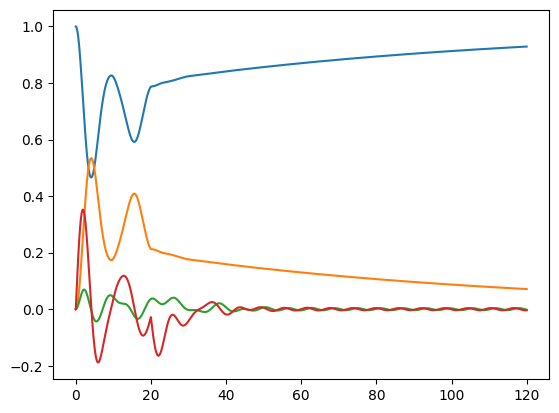

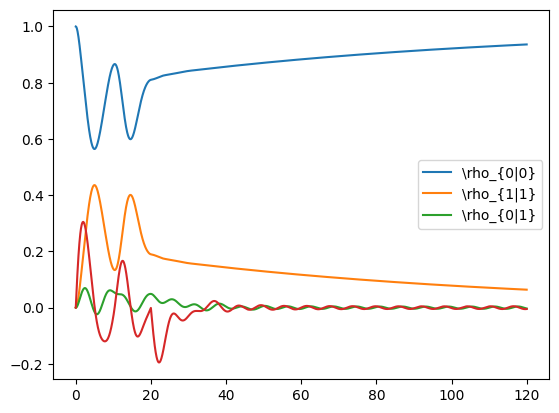

In [27]:

figure()
plot(tSteps,  res[:,:,0].mean(axis=-1) )
plot(tSteps,  res[:,2,0].mean(axis=-1).imag )

figure()
plot(tSteps,  res[:,:,-1].mean(axis=-1).real )
plot(tSteps,  res[:,2,-1].mean(axis=-1).imag )

legend(sys.symsD['prop_state_syms'])

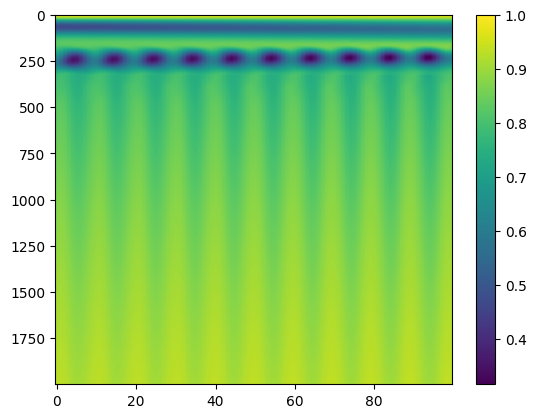

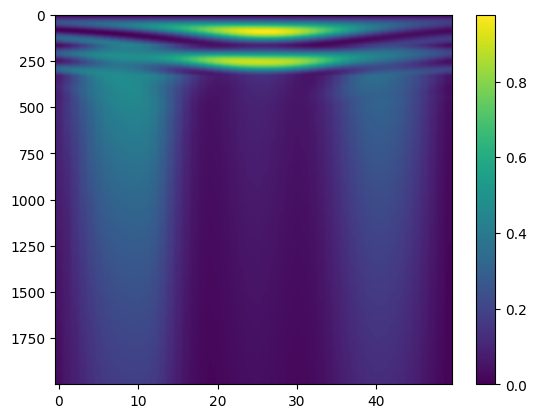

In [28]:
imshow(np.abs(res[:,0].mean(axis=-1)), aspect='auto')
colorbar()
figure()
imshow((res[:,1].mean(axis=1)).real, aspect='auto')
colorbar()

# Some specific situations of interest

## GEM (TODO)

In [29]:
K1.K1, K2  = q.basis(2,0), q.basis(2,1)
tS, zS = sm.symbols('t, z', real=True)
EexS,EintS, EtotS = sm.symbols('E_ex, E_int, E_tot', complex=True)
E_subs_D = {EtotS: EexS + EintS}
H0 = 0*K2*K2.dag()
H1a = K2*K1.dag() 
H1b = K1*K2.dag()
sx=K2*K1.dag() + K1*K2.dag()
sy=1j*K2*K1.dag() - 1j*K1*K2.dag()
c_opL = [sqrt(1)*K1*K2.dag() ] #Decoherence
H_desc = [H0, [EtotS, H1a], [sm.conjugate(EtotS), H1b]]


eq, ex_vals=h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1a], bReturnMatrixEquation=True)
display(eq, ex_vals)

nDims = len(ode_s.state_shape)-1
nStates = ode_s.state_shape[0]
nDriving = len(ode_s.symsD.driving_syms)

lhsL, rhsL = h.seperate_DM_equation(eq.subs(E_subs_D))
pol_exp = ex_vals[0].subs(E_subs_D)
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={zS: linspace(0,1,100)}, driving_syms=[EexS], bDecompose_to_re_im=True)
if 1:
    #pol_exp=pol_exp.subs(ode_s.complex_subsD)
    polF=sm.lambdify( ode_s.symsD_orig['prop_state_syms'],pol_exp, dummify=True)
else:
    polF=sm.lambdify( ode_s.symsD['prop_state_syms'],pol_exp, dummify=True)

zAx = ode_s.dimAxes[0]
dz = zAx[1]-zAx[0]

#def calcPolFieldF(t, z,rho00, rho11, rho01,Eex):
def calcPolFieldF(t, dimAxs,state,driving):
    #pdb.set_trace()
    pol = polF(*state)
    #P = -1j*np.cumsum(polF(rho00, rho11, rho01))*dz*1
    P = -1j*np.cumsum(polF(*state))*dz*1
    #print(state[2].sum()) 
 
    return P
calcPolFieldF.num=0

ode_s.set_driving({EexS: lambda t: -0.5 if t<20 else 0})
ode_s.set_state_dep_funcs({EintS:calcPolFieldF})
ode_s.set_initial_conditions(np.tile(array([1,0,0]), (100,1) ).T.astype('c16'))
ode_s.setup()

NameError: name 'h' is not defined

## Hole-burning in a cavity (TODO)

# Scrap

# Copying pyMBE (WIP)

Will use spl.makeBlochOperators to mimic the old pyMBE examples (non-spatial dependent). Spatial dependence may be added as shown above.

First make the operators (same arguments as pyMBE).
Note that the returned driving operator ("dest") is a non-Hermition lowering operator now. in pyMBE it's dest.dag()*dest

In [63]:
#
H0, [EinS, dest], [DeltaS, Hdet], c_opL=h.makeBlochOperators(gsEnergies= [0,1], esEnergies=[0], osc_strengths=np.array([[1],[1]]) ,
                        T1_opt=2)
H_desc = [H0, (EinS, dest), (sm.conjugate(EinS), dest.H), (DeltaS, Hdet) ]


Make the equations of motion

In [64]:
eq, ex_vals=h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [dest], bReturnMatrixEquation=True)
display(eq, ex_vals)

                                       ⎡                                      
                                       ⎢                           __         
⎡\rho_{0|0}  \rho_{0|1}  \rho_{0|2}⎤   ⎢       1.0⋅ⅈ⋅Ef⋅\rho_{0|2}⋅Ef + 0.5⋅\r
⎢                                  ⎥   ⎢                                      
⎢__________                        ⎥   ⎢                         ⎛            
⎢\rho_{0|1}  \rho_{1|1}  \rho_{1|2}⎥ = ⎢                    __   ⎜          2 
⎢                                  ⎥   ⎢1.0⋅ⅈ⋅Ef⋅\rho_{1|2}⋅Ef + ⎝- 0.5⋅ⅈ⋅Ef  
⎢__________  __________            ⎥   ⎢                                      
⎣\rho_{0|2}  \rho_{1|2}  \rho_{2|2}⎦   ⎢                                      
                                       ⎢                  __                  
                                       ⎣- ⅈ⋅Ef⋅\rho_{0|0}⋅Ef + 1.0⋅ⅈ⋅Ef⋅\rho_{

           ⎛                      2⎞                                          
           ⎜          2         __ ⎟ __________    

Define the simulation

In [65]:
detAx = linspace(-1,1,50)
tSteps = linspace(0,10,1000)
EinFw = lambda t: .5 + 0.0j if (t>1) and (t<3) else 0
lhsL, rhsL = h.seperate_DM_equation(eq)
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ), dims={DeltaS:detAx }, backend='numpy')
p0 = zeros(ode_s.state_shape)
p0[0] = 1. #Start everything in the first ground state
ode_s.set_driving({EinS:EinFw})
ode_s.set_initial_conditions(p0)
ode_s.setup()


Munch({'tSym': t, 'dimSyms': [Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{2|2}, \rho_{0|1}, \rho_{0|2}, \rho_{1|2}], 'stationary_state_syms': [], 'driving_syms': [], 'state_dep_syms': [Delta, Ef]})
state dependent functions should have signature [t, Delta, \rho_{0|0}, \rho_{1|1}, \rho_{2|2}, \rho_{0|1}, \rho_{0|2}, \rho_{1|2}]


Not integrating first step (it's just the initial state)
CPU times: user 362 ms, sys: 16.7 ms, total: 378 ms
Wall time: 372 ms


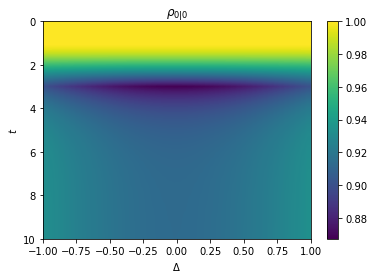

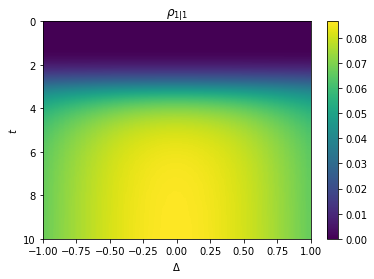

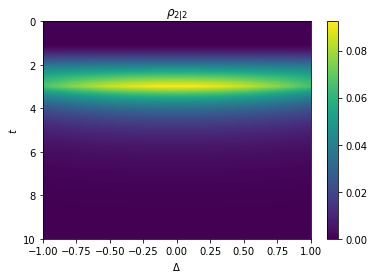

In [66]:
%time ode_s.integrate(tSteps, 0.01)
outA = np.array(ode_s.outputL).copy()
for k in range(3):
    figure()
    imshow(outA[:,k,:].real, aspect='auto', extent=[detAx[0], detAx[-1], tSteps[-1], tSteps[0]])

    xlabel(r"$\Delta$")
    ylabel('$t$')
    colorbar()
    title(r'${}$'.format(lhsL[k]) )

In [200]:
p0.shape

In [149]:
from scipy import interpolate
def EinFwF(t):
    return EinFwF.intp(t)
#interpolate.interp1d?

In [147]:
EinA[:] = np.where( (tAx>0) & (tAx<1), 1.0, 0 )*1
EinIntp  =interpolate.interp1d(tAx, EinA, copy=False)
EinFwF.intp = EinIntp
display(EinFwF(0.5))

EinA[:] = np.where( (tAx>0) & (tAx<1), 1.0, 0 )*5
display(EinIntp(.5))

array(1.)

array(1.)

In [165]:
tAx = linspace(-0.1,10.1,1000)
EinA = np.where( (tAx>1) & (tAx<5), 1.0, 0 )*1e-5
EinIntp  =interpolate.interp1d(tAx, EinA)
def EinFwF(t):
    return EinFwF.intp(t)
EinFwF.intp = EinIntp

ode_s.set_driving({EinS:EinFwF})
%time ode_s.setup() 
%time ode_s.integrate(tSteps, 0.01)
outA1 = np.array(ode_s.outputL).copy()

EinA[:] = np.where( (tAx>0) & (tAx<np.pi), 1.0, 0 )*1
EinIntp  =interpolate.interp1d(tAx, EinA, copy=False)
EinFwF.intp = EinIntp
%time ode_s.integrate(tSteps, 0.01)
outA2 = np.array(ode_s.outputL)

CPU times: user 23 ms, sys: 0 ns, total: 23 ms
Wall time: 22.6 ms
Not integrating first step (it's just the initial state)
CPU times: user 211 ms, sys: 6 ms, total: 217 ms
Wall time: 209 ms
Not integrating first step (it's just the initial state)
CPU times: user 276 ms, sys: 26 ms, total: 302 ms
Wall time: 280 ms


Text(0.5, 1.0, 'excitation')

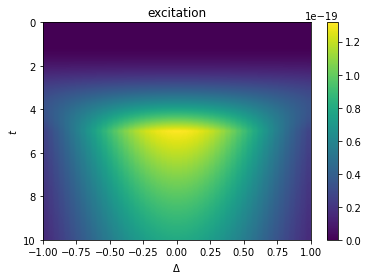

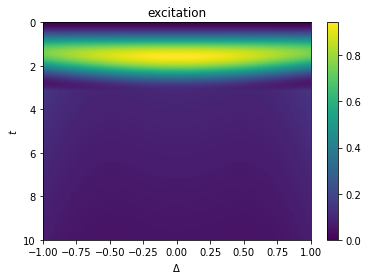

In [166]:
imshow(outA1[:,1,:].real, aspect='auto', extent=[detAx[0], detAx[-1], tSteps[-1], tSteps[0]])
xlabel(r"$\Delta$")
ylabel('$t$')
colorbar()
title('excitation')
figure()
imshow(outA2[:,1,:].real, aspect='auto', extent=[detAx[0], detAx[-1], tSteps[-1], tSteps[0]])
xlabel(r"$\Delta$")
ylabel('$t$')
colorbar()
title('excitation')

In [18]:
zAx = linspace(0,1,30)
detAx = linspace(-1,1,50)
tSteps = linspace(0,10,1000)
EinFw = lambda t: .01 + 0.0j if (t>1) and (t<3) else 0 #where( (tSteps>1) & (tSteps<3), 1.0, 0) 
lhsL, rhsL = h.seperate_DM_equation(eq)
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={zS: zAx, DeltaS:detAx }, driving_syms=[EexS], backend='numpy')
polF=sm.lambdify( ode_s.symsD['prop_state_syms'],ex_vals[0] )
zAx = ode_s.dimAxes[0]
dz = zAx[1]-zAx[0]
display(dz)
lineShape= 0.5*ones_like(detAx)/sqrt(detAx.size)*dz

def calcPolFieldF(t, dimAxs, state,  driving, lineShape=lineShape):
    #P = -1j*np.cumsum(polF(*state).T)*dz* lineShape
    P = -1j*np.cumsum( (polF(*state)*lineShape).sum(axis=1), axis=0)
    return P.reshape(dimAxs[0].shape)
#def calcPolFieldF(t, delt, z,rho00, rho11, rho01,Eex):
#    P = -1j*np.cumsum(polF(rho00, rho11, rho01))*dz*1
#    return P
p0 = zeros(ode_s.state_shape)
p0[0] = 1

ode_s.set_driving({EexS:EinFw})
ode_s.set_state_dep_funcs({EinS:calcPolFieldF})
ode_s.set_initial_conditions(p0)
ode_s.setup()
#dy_dtD = h.makeMESymb(hamilParams)

ode_s.integrate(tSteps, 0.01)
outA = np.array(ode_s.outputL)

Munch({'tSym': t, 'dimSyms': [z, Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{2|2}, \rho_{0|1}, \rho_{0|2}, \rho_{1|2}], 'stationary_state_syms': [], 'driving_syms': [E_ex], 'state_dep_syms': [Delta, Ef]})
state dependent functions should have signature [t, z, Delta, \rho_{0|0}, \rho_{1|1}, \rho_{2|2}, \rho_{0|1}, \rho_{0|2}, \rho_{1|2}, E_ex]


Not integrating first step (it's just the initial state)


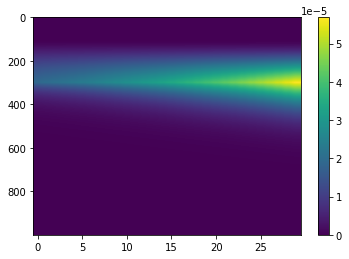

In [19]:
imshow(outA[:,2,:,detAx.size//2].real, aspect='auto')
colorbar()

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, '0.034482758620689655')

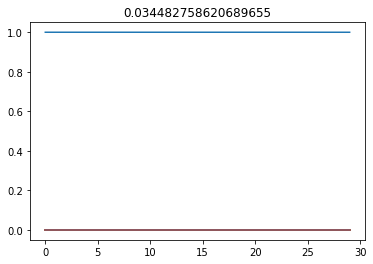

In [20]:
plot(outA[:,:,:,detAx.size//2].mean(axis=0).T)
title(dz)

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, '0.034482758620689655')

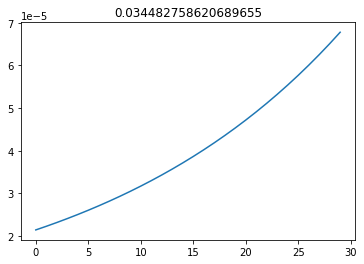

In [21]:
plot(outA[:,1,:,detAx.size//2].mean(axis=0))
title(dz)

In [ ]:
polF=sm.lambdify( ode_s.symsD['prop_state_syms'],ex_vals[0] )
zAx = ode_s.dimAxes[0]
dz = zAx[1]-zAx[0]

#def calcPolFieldF(t, z,rho00, rho11, rho01,Eex):
def calcPolFieldF(t, dimAxs,state,driving):
    #P = -1j*np.cumsum(polF(rho00, rho11, rho01))*dz*1
    P = -1j*np.cumsum(polF(*state))*dz*1
    return P
calcPolFieldF.num=0

ode_s.set_driving({EexS: lambda t: -0.5 if t<20 else 0})
ode_s.set_state_dep_funcs({EinS:calcPolFieldF})
ode_s.set_initial_conditions(np.tile(array([1,0,0]), (100,1) ).T.astype('c16'))
ode_s.prepare_for_integration()

In [82]:
import inspect

def f(a,b=2, c=4):
    return a, b+c**2

In [83]:
sig=inspect.signature(f)

In [91]:
len(sig.parameters)

In [90]:
sig

<Signature (a, b=2, c=4)>

In [92]:
sig.bind_partial?

Signature: sig.bind_partial(*args, **kwargs)
Docstring:
Get a BoundArguments object, that partially maps the
passed `args` and `kwargs` to the function's signature.
Raises `TypeError` if the passed arguments can not be bound.
File:      c:\users\morgan\anaconda3\envs\pymbe\lib\inspect.py
Type:      method


Munch({'tSym': t, 'dimSyms': [], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}], 'stationary_state_syms': [], 'driving_syms': [E], 'state_dep_syms': []})
state dependent functions should have signature [t, \rho_{0|0}, \rho_{1|1}, \rho_{0|1}, E]
CPU times: user 227 ms, sys: 1 ms, total: 228 ms
Wall time: 250 ms


/home/morgan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


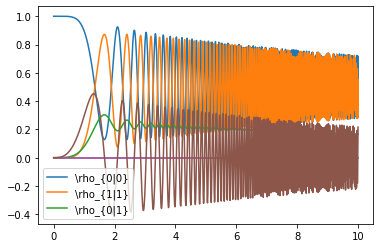

In [7]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS = sm.symbols('t')
ES = sm.symbols("E", complex=True)
H0 = 1*K2*K2.dag()
H1 = K1*K2.dag() #+ K2*K1.dag() 
c_opL = [sqrt(.1)*K1*K2.dag()]
#c_opL = [L(op) for op in c_opL]

H_desc = [H0, [ES, H1], [sm.conjugate(ES), H1.dag()]]
eq, ex_vals=h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1], bReturnMatrixEquation=True)
lhsL, rhsL = h.seperate_DM_equation(eq)
#(diagL,diag_dtL), (cohL, coh_dtL), e_op_L = h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1])
if 0:
    display("Bloch equations:")
    display(eq)
    display("Polarisation:")
    display(ex_vals)
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={}, driving_syms=[ES])#, backend='tensorflow')
ode_s.set_driving({ES: lambda t: -t**2})
#ode_s.set_state_dep_funcs({})
ode_s.set_initial_conditions(np.array([1,0,0]) )
ode_s.setup()

tSteps = linspace(0,10,1000)
%time out=ode_s.integrate(tSteps, 1.0)

plot(tSteps,  np.array(ode_s.outputL).squeeze() )
plot(tSteps,  np.array(ode_s.outputL).squeeze().imag )
legend(ode_s.symsD['prop_state_syms'])

## More scrap

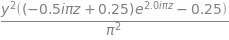

In [59]:

x,y,z, n = sm.symbols("x, y, z, n")
fwM=sm.Function("fwM")(z) #sm.exp(1j*2*sm.pi*z)
fwM = sm.exp(1j*2*sm.pi*z)
ex=sm.integrate(y**2*z*fwM, (z,0,z) ) 
ex.simplify()

In [54]:
lm=sm.lambdify((z,fwM,y), ex, modules='numpy')

In [32]:
sm.summation(z*y**2)

In [50]:
sm.lambdify?

In [55]:
sm.r

In [57]:
lm??

In [61]:
import tensorflow as tf

In [62]:
tf.__version__

'1.13.1'

## Make rho testing

In [165]:
import sympy as sm
from sympy.physics import quantum
import itertools as ito
def makeHermS(M):
    """ Make a symbollic matrix hermitian by mirroring the upper-diagonal elements and conjugating"""
    Nstates=M.shape[0]
    rIL, cIL = np.tril_indices(Nstates, -1)
    rIU, cIU = np.triu_indices(Nstates, 1)
    M=M.subs({M[rl,cl]: sm.conjugate(M[cl,rl]) for ru,cu, rl,cl in zip(rIU, cIU, rIL, cIL)})
    return M

In [183]:
I_tot = 1/2
S_tot = 1/2
N_I = int(2*(I_tot+1)-1)
N_S = int(2*(S_tot+1)-1)
ind_I_L = arange(N_I, dtype='i8')
ind_S_L = arange(N_S, dtype='i8')

rhoI = sm.Matrix(N_I, N_I, sm.symbols("rho^I_0:{0}_0:{0}".format( int(N_I) )) )
rhoS = sm.Matrix(N_S, N_S, sm.symbols("rho^S_0:{0}_0:{0}".format( int(N_S) )) )

In [185]:
rhoSubsD={sm.symbols(r"\rho^I_{{{0}{1}}}".format(k_I1,k_I2))*\
               sm.symbols(r"rho^S_{0}_{1}".format(k_S1,k_S2)):\
              #sm.symbols(r"\rho_\frac{{{0}}}{{2}}_{1}_{2}_{3}".format(k_I1,k_I2,k_S1,k_S2)) \
              sm.symbols(r"rho_{0}_{1}_{2}_{3}".format(k_I1,k_I2,k_S1,k_S2)) \
               for k_I1, k_I2, k_S1,k_S2 in ito.product(ind_I_L, ind_I_L, ind_S_L, ind_S_L) }

rhoM=makeHermS(quantum.TensorProduct(rhoI,rhoS).subs(rhoSubsD))

In [219]:
labels1 = ['0', '1', '2']
labels2 = ['A', 'B']
N = len(labels1) * len(labels2)
rhoS =sm.Array([sm.symbols('\\rho_{{{}{}|{}{}}}'.format(s1,s3,s2,s4)) for s1,s2,s3,s4 in  ito.product(labels1, labels2, labels1, labels2)]).reshape(N,N)

Options for making general matrices (including tensor-ed tensors)
1. get sympy to tensorproduct density matrices, then do a replace by looking at the atoms in each entry.
2. Work out the general formula for each element
3. Do the 2-input algorithm recursivley

In [220]:
makeHermS(rhoS)

⎡\rho_{00|AA}  \rho_{00|AB}  \rho_{01|AA}  \rho_{01|AB}  \rho_{02|AA}  \rho_{0
⎢                                                                             
⎢____________                                                                 
⎢\rho_{00|AB}  \rho_{00|BB}  \rho_{01|BA}  \rho_{01|BB}  \rho_{02|BA}  \rho_{0
⎢                                                                             
⎢____________  ____________                                                   
⎢\rho_{01|AA}  \rho_{01|BA}  \rho_{11|AA}  \rho_{11|AB}  \rho_{12|AA}  \rho_{1
⎢                                                                             
⎢____________  ____________  ____________                                     
⎢\rho_{01|AB}  \rho_{01|BB}  \rho_{11|AB}  \rho_{11|BB}  \rho_{12|BA}  \rho_{1
⎢                                                                             
⎢____________  ____________  ____________  ____________                       
⎢\rho_{02|AA}  \rho_{02|BA}  \rho_{12|AA}  \rho_{12|

In [221]:
list(enumerate(labels1))

[(0, '0'), (1, '1'), (2, '2')]

In [243]:
l=list(ito.product(labels1,labels2))
['{{{0}|{1}}}'.format(el1,el2) for el1, el2 in l]

['{0|A}', '{0|B}', '{1|A}', '{1|B}', '{2|A}', '{2|B}']

In [240]:
list(ito.product(labels2,labels1))

[('A', '0'), ('A', '1'), ('A', '2'), ('B', '0'), ('B', '1'), ('B', '2')]

In [263]:
def getRhoLabels(labels):
    labs=[['{}{}'.format(lab1, lab2) for lab1 in labels] for lab2 in labels]
    return labs

def getTensoredLabels(*args):
    labels_list_list = list(args)
    labels_cur = labels_list_list.pop()
    #labels_ = args.pop()
    mat_labels_cur = getRhoLabels(labels_cur)
    while labels_list_list:
        mat_labels_next = getRhoLabels(labels_list_list.pop())
        mat_labels_cur=_getTensoredLabels(mat_labels_next, mat_labels_cur)
    return mat_labels_cur
    #mat_labelsL = [getRhoLabels(labels) for labels in args]
    #['{}|{}'.format(lab1, lab2) for lab1 in mat2_labels
def _getTensoredLabels(mat_labels1, mat_labels2):
    N1 = len(mat_labels1)
    N2 = len(mat_labels2)
    labelM = np.empty((N1*N2,N1*N2), dtype='O')

    for i1 in arange(N1):
        for k1 in arange(N1):
            for i2 in arange(N2):
                for k2 in arange(N2):
                   labelM[i1*N2+i2, k1*N2+k2] = '{}|{}'.format(mat_labels1[i1][k1], mat_labels2[i2][k2])
        
    return labelM

def getTensoredRhoS(*args ):
    st = '\\rho_{{{}}}'
    labsMat=getTensoredLabels(*args)
    rhoM = np.empty_like(labsMat)
    N = rhoM.shape[0]
    for i in range(N):
        for k in range(N):
            if k < i:
                sym = sm.conjugate(rhoM[k,i]) 
            else:
                sym_st = st.format(labsMat[i,k])
                if k == i :
                    sym = sm.symbols(sym_st, real=True)
                else:
                    sym = sm.symbols(sym_st, real=False)

            rhoM[i, k] = sym
    return sm.Matrix(rhoM)
#getRhoLabels('abc')
getTensoredRhoS('12','ab', 'mn')


⎡\rho_{11|aa|mm}  \rho_{11|aa|nm}  \rho_{11|ba|mm}  \rho_{11|ba|nm}  \rho_{21|
⎢                                                                             
⎢_______________                                                              
⎢\rho_{11|aa|nm}  \rho_{11|aa|nn}  \rho_{11|ba|mn}  \rho_{11|ba|nn}  \rho_{21|
⎢                                                                             
⎢_______________  _______________                                             
⎢\rho_{11|ba|mm}  \rho_{11|ba|mn}  \rho_{11|bb|mm}  \rho_{11|bb|nm}  \rho_{21|
⎢                                                                             
⎢_______________  _______________  _______________                            
⎢\rho_{11|ba|nm}  \rho_{11|ba|nn}  \rho_{11|bb|nm}  \rho_{11|bb|nn}  \rho_{21|
⎢                                                                             
⎢_______________  _______________  _______________  _______________           
⎢\rho_{21|aa|mm}  \rho_{21|aa|mn}  \rho_{21|ab|mm}  

In [252]:

def getTensorProductLabels(labels1,labels2):
    N1 = len(labels1)
    N2 = len(labels2)
    indM = np.empty((N1*N2,N1*N2), dtype='O')

    for i1 in arange(N1):
        for k1 in arange(N1):
            for i2 in arange(N2):
                for k2 in arange(N2):
                   indM[i1*N2+i2, k1*N2+k2] = [(labels1[i1], labels1[k1]),(labels2[i2], labels2[k2]) ] 
    return indM

def getRhoTensorS(labels1, labels2, labels3 ):
    st = '\\rho_{{{0}{1}|{2}{3}}}'#.format(s1,s3,s2,s4)
    #symName = lambda i1, i2: '\\rho_{{{0}|{1}}}'.format(i1,i2)
    #symName = lambda i1, i2: '\\rho_{{{0}{1}|{2}{3}}}'.format(i1,i2)
    N1 = len(labels1)
    
    N2 = len(labels2) *len(labels3)
    l=list(ito.product(labels2,labels3))
    labels2 = ['{{{0}{1}}}'.format(el1,el2) for el1, el2 in l]
    rhoM = np.empty((N1*N2,N1*N2), dtype='O')

    for i1 in arange(N1):
        for k1 in arange(N1):
            for i2 in arange(N2):
                for k2 in arange(N2):
                    i_, k_ = i1*N2+i2, k1*N2+k2
                    if k_ < i_:
                        sym = sm.conjugate(rhoM[k_,i_]) 
                    else:
                        sym_st = st.format(labels1[i1], labels1[k1],labels2[i2], labels2[k2])
                        if k_ == i_ :
                            sym = sm.symbols(sym_st, real=True)
                        else:
                            sym = sm.symbols(sym_st, real=False)
                                         
                    rhoM[i_, k_] = sym  
    return sm.Matrix(rhoM)

    M = np.empty((Nstates,Nstates), dtype='O')
    DI = np.diag_indices(Nstates)
    UI = np.triu_indices(Nstates, 1)
    for inds in zip(*DI):
        M[inds[0], inds[1]] = sm.symbols(symName(*inds), real=True)
    for inds in zip(*UI):
        sym =  sm.symbols(symName(*inds), complex=True)
        M[inds[0], inds[1]] =sym
        M[inds[1], inds[0]] = sm.conjugate(sym)

    return sm.Matrix(M)


In [249]:
getTensorProductLabels('01', 'AB')

array([[list([('0', '0'), ('A', 'A')]), list([('0', '0'), ('A', 'B')]),
        list([('0', '1'), ('A', 'A')]), list([('0', '1'), ('A', 'B')])],
       [list([('0', '0'), ('B', 'A')]), list([('0', '0'), ('B', 'B')]),
        list([('0', '1'), ('B', 'A')]), list([('0', '1'), ('B', 'B')])],
       [list([('1', '0'), ('A', 'A')]), list([('1', '0'), ('A', 'B')]),
        list([('1', '1'), ('A', 'A')]), list([('1', '1'), ('A', 'B')])],
       [list([('1', '0'), ('B', 'A')]), list([('1', '0'), ('B', 'B')]),
        list([('1', '1'), ('B', 'A')]), list([('1', '1'), ('B', 'B')])]],
      dtype=object)

In [248]:
getRhoTensorS('01', 'AB', 'MN')

⎡\rho_{00|{AM}{AM}}  \rho_{00|{AM}{AN}}  \rho_{00|{AM}{BM}}  \rho_{00|{AM}{BN}
⎢                                                                             
⎢__________________                                                           
⎢\rho_{00|{AM}{AN}}  \rho_{00|{AN}{AN}}  \rho_{00|{AN}{BM}}  \rho_{00|{AN}{BN}
⎢                                                                             
⎢__________________  __________________                                       
⎢\rho_{00|{AM}{BM}}  \rho_{00|{AN}{BM}}  \rho_{00|{BM}{BM}}  \rho_{00|{BM}{BN}
⎢                                                                             
⎢__________________  __________________  __________________                   
⎢\rho_{00|{AM}{BN}}  \rho_{00|{AN}{BN}}  \rho_{00|{BM}{BN}}  \rho_{00|{BN}{BN}
⎢                                                                             
⎢__________________  __________________  __________________  _________________
⎢\rho_{01|{AM}{AM}}  \rho_{01|{AN}{AM}}  \rho_{01|{B

In [237]:
sm.Array?

In [179]:
N1 = 2
N2 = 2
ind_mat1 =  []

for  k in range(N1):
    fo

⎡ρ_0_0__I⋅ρ_0_0__S  ρ_0_0__I⋅ρ_0_1__S  ρ_0_1__I⋅ρ_0_0__S  ρ_0_1__I⋅ρ_0_1__S⎤
⎢                                                                          ⎥
⎢________ ________                                                         ⎥
⎢ρ_0_0__I⋅ρ_0_1__S  ρ_0_0__I⋅ρ_1_1__S  ρ_0_1__I⋅ρ_1_0__S  ρ_0_1__I⋅ρ_1_1__S⎥
⎢                                                                          ⎥
⎢________ ________  ________ ________                                      ⎥
⎢ρ_0_1__I⋅ρ_0_0__S  ρ_0_1__I⋅ρ_1_0__S  ρ_1_1__I⋅ρ_0_0__S  ρ_1_1__I⋅ρ_0_1__S⎥
⎢                                                                          ⎥
⎢________ ________  ________ ________  ________ ________                   ⎥
⎣ρ_0_1__I⋅ρ_0_1__S  ρ_0_1__I⋅ρ_1_1__S  ρ_1_1__I⋅ρ_0_1__S  ρ_1_1__I⋅ρ_1_1__S⎦

In [172]:
rhoSubsD

In [2]:
import MT
gauss = MT.gauss


In [4]:
t = linspace(0,1,1000)
y = MT.gauss(t, [1, 0.5, 0.1])
plot(t, y)

#fax = fftfreq(t.size, t[1]-t[0])
#y = 

NameError: name 'linspace' is not defined

# TF testing

In [2]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import qutip as q
from spylind import spylind as spl
from spylind import spyIVP as spi
from spylind.tf_misc import tf_interpolator2

from math import *
import numpy as np
import sympy as sm
from matplotlib.pyplot import *


#problem definition
K1, K2  = q.basis(2,0), q.basis(2,1), 
tS, DeltaS = sm.symbols('t, Delta', real=True)
ES_r, ES_i = sm.symbols("E_r, E_i", real=True)
H0 = 5*K2*K2.dag()
c_opL = [sqrt(.1)*q.sigmap()]

H_desc = [H0, [ES_r, q.sigmax()], [ES_i, q.sigmay()], [DeltaS, K2*K2.dag()] ]
eq, ex_vals=spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [], bReturnMatrixEquation=True)
lhsL, rhsL = spl.seperate_DM_equation(eq)

ode_s = spi.ODESolver(dict(zip(lhsL, rhsL) ),  dims={DeltaS:np.linspace(-2,2,100)}, driving_syms=[ES_r, ES_i], bDecompose_to_re_im=True, backend='tensorflow')
ode_s.set_initial_conditions(np.array([1,0,0]) )


tDrv = np.linspace(0,2.1,100)
tDrv -= (tDrv[1]-tDrv[0])/2
def calc_g(drv):
    drv_r, drv_i = drv[:tDrv.size], drv[tDrv.size:]#drv_cmplx.real, drv_cmplx.imag

    tSteps = np.linspace(0,1.99,20)

    with tf.device("/cpu:0"):
        with tf.GradientTape(watch_accessed_variables=False) as g:
            drv_r0 =tf.convert_to_tensor(drv_r, dtype='float64')
            drv_i0 =tf.convert_to_tensor(drv_i, dtype='float64')
            g.watch(drv_r0)
            g.watch(drv_i0)
            drv_r = 5*tf.math.tanh(drv_r0)
            drv_i = 5*tf.math.tanh(drv_i0)

            f_driving_r = tf.function(tf_interpolator2(tDrv, drv_r), experimental_compile=False)
            f_driving_i = tf.function(tf_interpolator2(tDrv, drv_i), experimental_compile=False)

            ode_s.set_driving({ES_r:f_driving_r, ES_i:f_driving_i})
            ode_s.setup(bForceStateDimensions=True)
            #g.watch(p0)

            #arr =ode_s.integrate(tSteps, 1.0)
            tStart = time.time()
            
            arr = ode_s.integrate(tSteps,1.0, method='rk4', solver_options=dict(step_size = (tDrv[1]-tDrv[0])) ) 
            print("time taken: ", tStart-time.time())
            #print(arr.shape)
            #L=tf.pow(tf.reduce_mean(arr[-1,1]), 2)
            L=tf.reduce_mean(arr[-5:-4,0]**2)
            #L = arr[-8:,1, 1]**2
            #L = arr[-5:,1]

    print(L.numpy())
    grad = g.gradient(L, [drv_r0, drv_i0] )
    #grad_i = g.gradient(L, drv_i)

    return arr.numpy(), np.hstack([grad[0].numpy(), grad[1].numpy()]), L







The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Munch({'tSym': t, 'dimSyms': [Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}^r, \rho_{0|1}^i], 'stationary_state_syms': [], 'driving_syms': [E_r, E_i], 'state_dep_syms': [Delta]})
state dependent functions should have signature <itertools.chain object at 0x752545d296d0>


In [4]:
y0 = 1.*tDrv*(1+1j)
vals, grad, L =calc_g(np.hstack([y0.real, y0.imag]) )

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.4927794933319092
0.3428455539448771


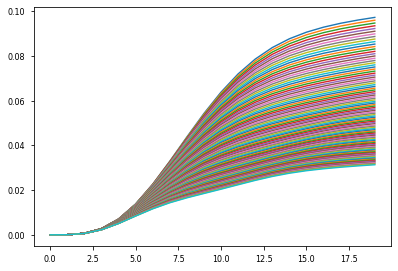

In [171]:
res.shape
plot(res[:,1,:])

In [109]:
y0.size

100

In [198]:
from scipy import optimize
def f(yDrv):
    y, grad, L =calc_g(yDrv)
    return L.numpy().squeeze(), grad
res=optimize.minimize(f, np.hstack([y0.real, y0.imag]) , jac=True)
#res=optimize.minimize(f, res.x , jac=True)

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.649613857269287
0.3428455539448771
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.585284948348999
0.17143706802042744
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.5597412586212158
0.05907122438587313
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.4816558361053467
0.04956329910622964
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.123467206954956
0.04475203278570408
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.6092915534973145
0.043522926100682896
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.5531361103057861
0.04262404233959918
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.5179853439331055
0.041393650628348155
Nevals: <tf.Variable 'Variable:0' shape=()

In [189]:
fin, _, _ =calc_g(res.x )

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.590360403060913
0.006618243559740544


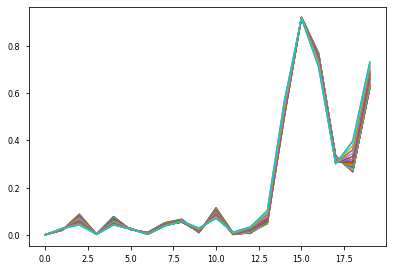

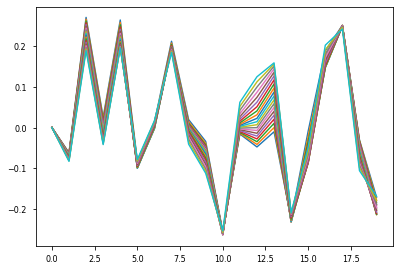

In [190]:
plot(fin[:,1,::5])
plot(fin[:,1,::5])
figure()
plot(fin[:,2,::5])

#plot(fin[:,:,50])

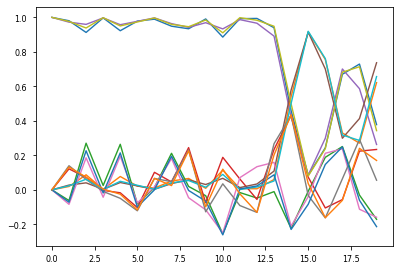

In [191]:
plot(fin[:,:,0])
plot(fin[:,:,-1])
plot(fin[:,:,50])

In [196]:
plot(res.x[:tDrv.size])
plot(res.x[tDrv.size:])
grid()

AttributeError: 'numpy.ndarray' object has no attribute 'x'

In [197]:
res

array([[[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.998497  ,  0.99849722,  0.99849744, ...,  0.99853194,
          0.99853244,  0.99853294],
        [ 0.001503  ,  0.00150278,  0.00150256, ...,  0.00146806,
          0.00146756,  0.00146706],
        [-0.02997417, -0.03000602, -0.03003777, ..., -0.03260473,
         -0.03262684, -0.03264883],
        [ 0.02430156,  0.02425776,  0.0242139 , ...,  0.01979241,
          0.01974359,  0.01969473]],

       [[ 0.97700891,  0.97702268,  0.97703662, ...,  0.97911034,
          0.97913935,  0.97916849],
        [ 0.02299109,  0.02297732,  0.02296338, ...,  0.02088966,
          0.

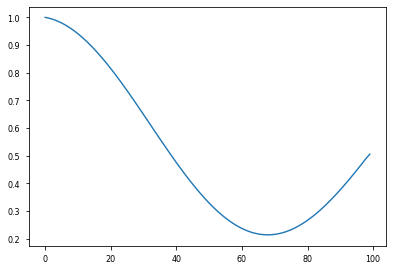

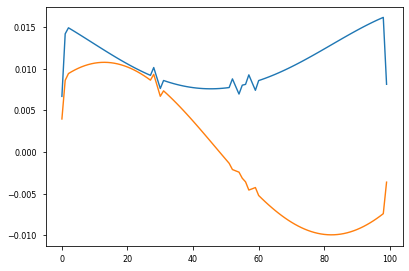

In [78]:
plot(res)

g_r, g_i = grad[:tDrv.size], grad[tDrv.size:]

figure()
plot(g_r)
plot(g_i)

In [40]:
#ode_s.set_driving({ES_r: tf.function(lambda t: -1*t**2), ES_i: tf.function(lambda t: 0*-1*t**2)})
#ode_s.tDepFD
tSteps = np.linspace(0,10,1000)
%time out=ode_s.integrate(tSteps, .5, method='rk4', solver_options=dict(step_size=0.001))

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=40000>
CPU times: user 28.4 s, sys: 1.19 s, total: 29.5 s
Wall time: 29.3 s


In [41]:
tSteps[1]-tSteps[0]

0.01001001001001001

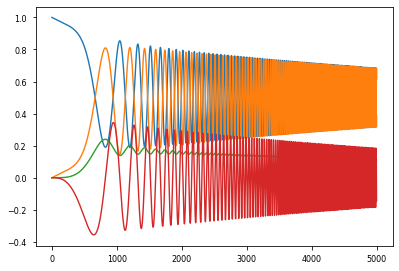

In [37]:
plot(out)

# Optimise 3-level

In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import qutip as q
from spylind import spylind as spl
from spylind import spyIVP as spi
from spylind.tf_misc import tf_interpolator2

from math import *
import numpy as np
import sympy as sm
from matplotlib.pyplot import *


#problem definition
K1, K2, K3  = q.basis(3,0), q.basis(3,1), q.basis(3,2)
tS, DeltaS = sm.symbols('t, Delta', real=True)
ES_r, ES_i = sm.symbols("E_r, E_i", real=True)

H0 = 2*K3*K3.dag() - 2*K1*K1.dag()
c_opL = [sqrt(2.)*K1*K2.dag(), sqrt(2.)*K3*K2.dag()]


a = K1*K2.dag() + K3*K2.dag()
sx = a + a.dag()
sy = 1j*(a.dag()-a)

H_desc = [H0, [ES_r, sx], [ES_i, sy], [DeltaS, K2*K2.dag()] ]
eq, ex_vals=spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [], bReturnMatrixEquation=True)
lhsL, rhsL = spl.seperate_DM_equation(eq)

ode_s = spi.ODESolver(dict(zip(lhsL, rhsL) ),  dims={DeltaS:np.linspace(-1,1,200)}, driving_syms=[ES_r, ES_i], bDecompose_to_re_im=True, backend='tensorflow')
ode_s.set_initial_conditions(np.array([1]+8*[0,0,]) )


tDrv = np.linspace(0,2.1,100)
tDrv -= (tDrv[1]-tDrv[0])/2
def calc_g(drv):
    drv_r, drv_i = drv[:tDrv.size], drv[tDrv.size:]#drv_cmplx.real, drv_cmplx.imag
    drv_r =tf.convert_to_tensor(drv_r, dtype='float64')
    drv_i =tf.convert_to_tensor(drv_i, dtype='float64')
    f_driving_r = tf.function(tf_interpolator2(tDrv, drv_r), experimental_compile=False)
    f_driving_i = tf.function(tf_interpolator2(tDrv, drv_i), experimental_compile=False)

    ode_s.set_driving({ES_r:f_driving_r, ES_i:f_driving_i})
    ode_s.setup(bForceStateDimensions=True)
    tSteps = np.linspace(0,1.99,10)

    with tf.device("/cpu:0"):
        with tf.GradientTape(watch_accessed_variables=False) as g:
            #g.watch(p0)
            g.watch(drv_r)
            g.watch(drv_i)
            #arr =ode_s.integrate(tSteps, 1.0)
            tStart = time.time()
            
            arr = ode_s.integrate(tSteps,1.0, method='rk4', solver_options=dict(step_size = (tDrv[1]-tDrv[0])) ) 
            print("time taken: ", tStart-time.time())
            #print(arr.shape)
            #L=tf.pow(tf.reduce_mean(arr[-1,1]), 2)
            L=tf.reduce_mean(1-arr[-1,2]**2)
            #L = arr[-8:,1, 1]**2
            #L = arr[-5:,1]

    print(L.numpy())
    grad = g.gradient(L, [drv_r, drv_i] )
    #grad_i = g.gradient(L, drv_i)

    return arr.numpy(), np.hstack([grad[0].numpy(), grad[1].numpy()]), L



No pretty printing stuff (probably because no Pandas)
Munch({'tSym': t, 'dimSyms': [Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{2|2}, \rho_{0|1}^r, \rho_{0|1}^i, \rho_{0|2}^r, \rho_{0|2}^i, \rho_{1|2}^r, \rho_{1|2}^i], 'stationary_state_syms': [], 'driving_syms': [E_r, E_i], 'state_dep_syms': [Delta]})
state dependent functions should have signature <itertools.chain object at 0x79e70ffd7280>


In [2]:
y0 = np.random.normal(size=tDrv.size) + 1j *np.random.normal(size=tDrv.size)
vals, grad, L =calc_g(np.hstack([y0.real, y0.imag]) )

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


num function evaluations: 1506
time taken:  -7.310337543487549
0.9991245291412131


AttributeError: 'NoneType' object has no attribute 'numpy'

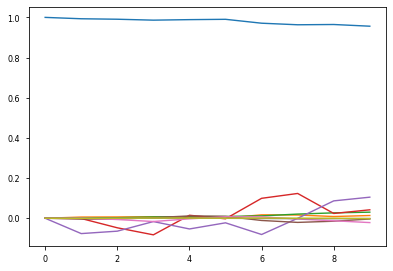

In [37]:
plot(vals[:,:,100])

In [ ]:
from scipy import optimize
def f(yDrv):
    y, grad, L =calc_g(yDrv)
    return L.numpy().squeeze(), grad
res=optimize.minimize(f, np.hstack([y0.real, y0.imag]) , jac=True)
#res=optimize.minimize(f, res.x , jac=True)

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.2180709838867188
0.9991128607393853
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.923414945602417
0.9991108527295529
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.9195196628570557
0.9991027837123267
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.817894697189331
0.9990699108769622
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.989755153656006
0.9989285405583952
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.578902006149292
0.998183139392259
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.8727903366088867
0.9908388968937899
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.841519594192505
0.8538858687081524
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32

In [ ]:
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={}, driving_syms=[ES], bDecompose_to_re_im=True)
ode_s.set_driving({ES: lambda t: -t**2})
#ode_s.set_initial_conditions(dict( zip(ode_s.symsD.prop_state_syms, [1,0,0,0]) ), bRealified=True )
ode_s.set_initial_conditions( [1,0,0], bRealified=False )
ode_s.setup()

In [ ]:
yDrv =tf.convert_to_tensor(yDrv, dtype='float64')
f_driving = tf.function(tf_interpolator2(tDrv, yDrv), experimental_compile=False)

ode_s.set_driving({drvS:f_driving})
ode_s.setup(bForceStateDimensions=True

In [ ]:
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={}, driving_syms=[ES], bDecompose_to_re_im=True)
ode_s.set_driving({ES: lambda t: -t**2})
#ode_s.set_initial_conditions(dict( zip(ode_s.symsD.prop_state_syms, [1,0,0,0]) ), bRealified=True )
ode_s.set_initial_conditions( [1,0,0], bRealified=False )
ode_s.setup()

## TFP Testing

In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import qutip as q
from spylind import spylind as spl
from spylind import spyIVP as spi
from spylind.tf_misc import InterpolatorMask, InterpolatorMaskArgs

from math import *
import numpy as np
import sympy as sm
from matplotlib.pyplot import *


#problem definition
K1, K2  = q.basis(2,0), q.basis(2,1), 
tS, DeltaS = sm.symbols('t, Delta', real=True)
ES_r, ES_i = sm.symbols("E_r, E_i", real=True)
H0 = 5*K2*K2.dag()
c_opL = [sqrt(.1)*q.sigmap()]

H_desc = [H0, [ES_r, q.sigmax()], [ES_i, q.sigmay()], [DeltaS, K2*K2.dag()] ]
eq, ex_vals=spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [], bReturnMatrixEquation=True)
lhsL, rhsL = spl.seperate_DM_equation(eq)

ode_s = spi.ODESolver(dict(zip(lhsL, rhsL) ),  dims={DeltaS:np.linspace(-2,2,100)}, driving_syms=[ES_r, ES_i], bDecompose_to_re_im=True, backend='tensorflow')
ode_s.set_initial_conditions(np.array([1,0,0]) )

tDrv = np.linspace(0,2.1,100)
tDrv -= (tDrv[1]-tDrv[0])/2

drv_r = np.ones(tDrv.size)
drv_i = drv_r*0
f_driving_r = InterpolatorMaskArgs(tDrv)
f_driving_i = InterpolatorMaskArgs(tDrv)

ode_s.set_driving({ES_r:f_driving_r, ES_i:f_driving_i})
#drivingD = {ES_r : [Interpolator2(tDrv), {"yOrig"=drv_r}], ES_i: [Interpolator2(tDrv), {'yOrig':drv_i}] }
#ode_s.set_driving(drivingD)
tSteps = np.linspace(0,1.99,50)
solver_options = {}
sim =ode_s.make_sim(tSteps, bForceStateDimensions=True, **solver_options, params =)
%time arr = sim.integrate(tSteps, driving_argsD={str(ES_r): [drv_r], str(ES_i): [drv_i]} ) 


SyntaxError: invalid syntax (<ipython-input-1-f8fbebaaa748>, line 42)

In [33]:
%time arr = ode_s.integrate(tSteps,  driving_argsD={str(ES_r): [drv_r], str(ES_i): [drv_i]}) 


Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=145>
CPU times: user 469 ms, sys: 8 ms, total: 477 ms
Wall time: 482 ms


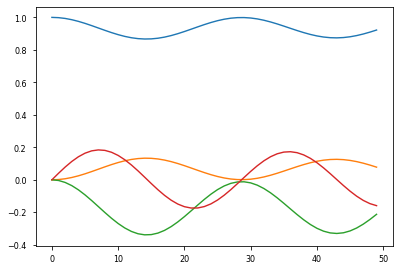

In [34]:
plot(arr[:,:, 50])

In [14]:

tSteps = np.linspace(0,1.99,10)

with tf.device("/cpu:0"):
    with tf.GradientTape(watch_accessed_variables=False) as g:
        #g.watch(p0)
        g.watch(drv_r)
        g.watch(drv_i)
        #arr =ode_s.integrate(tSteps, 1.0)
        tStart = time.time()

        arr = ode_s.integrate(tSteps,1.0, method='rk4', solver_options=dict(step_size = (tDrv[1]-tDrv[0])) ) 
        print("time taken: ", tStart-time.time())
        #print(arr.shape)
        #L=tf.pow(tf.reduce_mean(arr[-1,1]), 2)
        L=tf.reduce_mean(1-arr[-1,2]**2)
        #L = arr[-8:,1, 1]**2
        #L = arr[-5:,1]

print(L.numpy())
grad = g.gradient(L, [drv_r, drv_i] )
#grad_i = g.gradient(L, drv_i)

return arr.numpy(), np.hstack([grad[0].numpy(), grad[1].numpy()]), L

ValueError: Passed in object of type <class 'numpy.ndarray'>, not tf.Tensor

# More cavity calcs

In [143]:
from sympy import *
#x, y, t = symbols("x y t", real=True)
EinR, EinL, EincR, EincL = symbols('E^{in}_R, E^{in}_L, E^{inc}_R, E^{inc}_L ')
r1, r2, t1, t2, kL = symbols("r_1, r_2, tau_1, tau_2, kL", real=True)
eps, A= symbols('epsilon, A')
#display(E_T, E_R)
subsD={A: 1/(1-r1*r2*exp(2*sm.I*kL)), eps: exp(sm.I*kL), t1:sqrt(1-r1**2 ), t2:sqrt(1-r2**2) }

In [130]:
M = Matrix([
            [t1, t2*eps*r1, r2*eps*r1, r1], # x [EinFw, EinRv, EpolBack, EpolFront] = E_modefw 
            [t1*eps*r2, t2, r2, r1*eps*r2]  # E_moderv =
        ])*A
M

⎡  A⋅τ₁     A⋅ε⋅r₁⋅τ₂  A⋅ε⋅r₁⋅r₂    A⋅r₁   ⎤
⎢                                          ⎥
⎣A⋅ε⋅r₂⋅τ₁    A⋅τ₂       A⋅r₂     A⋅ε⋅r₁⋅r₂⎦

In [142]:
np.array(M.subs(subsD).subs({kL:10, r1:0.5, r2:0}), dtype='c16')

array([[ 0.8660254 +0.j        , -0.41953576-0.27201056j,
         0.        +0.j        ,  0.5       +0.j        ],
       [ 0.        +0.j        ,  1.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ]])

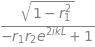

In [128]:
expr = M.subs(subsD)[0,0]
expr.simplify()
expr

In [119]:
display(M.subs(subsD).simplify())
display(M.subs(subsD).subs(subsD))

None

⎡          _________              _________                                   
⎢         ╱       2              ╱       2   1.0⋅ⅈ⋅kL            1.0⋅ⅈ⋅kL     
⎢       ╲╱  1 - r₁          r₁⋅╲╱  1 - r₂  ⋅ℯ             r₁⋅r₂⋅ℯ             
⎢  ─────────────────────    ─────────────────────────  ─────────────────────  
⎢           2.0⋅ⅈ⋅kL                   2.0⋅ⅈ⋅kL                 2.0⋅ⅈ⋅kL      
⎢  - r₁⋅r₂⋅ℯ         + 1      - r₁⋅r₂⋅ℯ         + 1    - r₁⋅r₂⋅ℯ         + 1  
⎢                                                                             
⎢      _________                      _________                               
⎢     ╱       2   1.0⋅ⅈ⋅kL           ╱       2                                
⎢r₂⋅╲╱  1 - r₁  ⋅ℯ                 ╲╱  1 - r₂                    r₂           
⎢─────────────────────────    ─────────────────────    ─────────────────────  
⎢           2.0⋅ⅈ⋅kL                   2.0⋅ⅈ⋅kL                 2.0⋅ⅈ⋅kL      
⎣  - r₁⋅r₂⋅ℯ         + 1      - r₁⋅r₂⋅ℯ         + 1 

In [106]:
aS = sm.symbols('a0:8')
bS = sm.symbols('b0:4')

M = Matrix([ [aS[0], aS[1], aS[2], aS[3]],
            [aS[4], aS[5], aS[6], aS[7]]])

In [156]:
M@np.array([bS[0], bS[1], bS[2], bS[3]])

array([b0*(0.668506940004621 + 0.383380462846531*I) + b1*(-0.249154784278535 - 0.484626606300663*I) + b2*(-0.249154784278535 - 0.484626606300663*I) + b3*(0.668506940004621 + 0.383380462846531*I),
       b0*(-0.249154784278535 - 0.484626606300663*I) + b1*(0.668506940004621 + 0.383380462846531*I) + b2*(0.668506940004621 + 0.383380462846531*I) + b3*(-0.249154784278535 - 0.484626606300663*I),
       b0*(-0.249154784278535 - 0.484626606300663*I) + b1*(-0.707106781186548 - 1.45337301221682e-16*I) + b2*(0.668506940004621 + 0.383380462846531*I) + b3*(-0.249154784278535 - 0.484626606300663*I),
       b0*(-0.707106781186548 - 1.45337301221682e-16*I) + b1*(-0.249154784278535 - 0.484626606300663*I) + b2*(-0.249154784278535 - 0.484626606300663*I) + b3*(0.668506940004621 + 0.383380462846531*I)],
      dtype=object)